# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [158]:
from utils import *

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import json
from torch import save, load

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [215]:
seed = 2133330296#randint(0, 4294967295)
print(seed)

2133330296


In [216]:
df = pd.read_csv('data/churn/customer_churn_telecom_services.csv', header=0)
print('Nº de instâncias:', len(df))
df.head()

Nº de instâncias: 7043


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [217]:
# Quantiades de cada valor único por coluna
nmrc_cols = []
cat_cols = []

for col in df.drop(columns=['Churn']).columns:
    unique_values = df[col].value_counts()
    if(len(unique_values) <= 4):
        print(unique_values, '\n')
        #df[col] = df[col].astype('category')
        cat_cols.append(col)
    else:
        nmrc_cols.append(col)

gender
Male      3555
Female    3488
Name: count, dtype: int64 

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64 

Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64 

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64 

TechSupport
No                     3473
Yes                    2044
No internet ser

In [218]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Alterando colunas categóricas binárias para int

#df_train1['gender'] = df_train1['gender'].apply(lambda x: 0 if x=='Male' else 1)

rdict = {'gender': {'Male': 0, 'Female': 1}, 
         'Partner': {'No': 0, 'Yes': 1},
         'Dependents': {'No': 0, 'Yes': 1},
         'PhoneService': {'No': 0, 'Yes': 1},
         'PaperlessBilling': {'No': 0, 'Yes': 1},
         'Churn': {'No': 0, 'Yes': 1},
         }

# Alterando colunas que são parcialmente dummy
# Exp.: OnlineSecurity: ("No internet service", "No", "Yes") -> (0, 1, 2)

rdict['MultipleLines'] = {'No phone service': 0, 'No': 1, 'Yes': 2}

cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
        'StreamingTV', 'StreamingMovies']

for col in cols:
    rdict[col] = {'No internet service': 0, 'No': 1, 'Yes': 2}

# Alterando colunas não-dummy

rdict['InternetService'] = {'No': 0, 'DSL': 1, 'Fiber optic': 2}

rdict['Contract'] = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}

rdict['PaymentMethod'] = {'Credit card (automatic)': 0, 'Bank transfer (automatic)': 1,
                          'Mailed check': 2, 'Electronic check': 3}

df = df.replace(rdict).rename(columns={'Churn': 'target'})
df.head()

/tmp/ipykernel_56247/3383695723.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(rdict).rename(columns={'Churn': 'target'})


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,1,0,1,0,1,0,0,1,1,2,1,1,1,1,0,1,3,29.85,29.85,0
1,0,0,0,0,34,1,1,1,2,1,2,1,1,1,1,0,2,56.95,1889.50,0
2,0,0,0,0,2,1,1,1,2,2,1,1,1,1,0,1,2,53.85,108.15,1
3,0,0,0,0,45,0,0,1,2,1,2,2,1,1,1,0,1,42.30,1840.75,0
4,1,0,0,0,2,1,1,2,1,1,1,1,1,1,0,1,3,70.70,151.65,1


In [219]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5
cols = df.drop(columns=['target']).columns

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [220]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
#Xa_test_norm = scaler.transform(Xa_test)

In [221]:
# Normalização no conjunto de treinamento
scaler1 = MinMaxScaler()

Xb_train_norm = Xb_train.copy()
Xb_train_norm.loc[:,nmrc_cols] = scaler1.fit_transform(Xb_train_norm.loc[:,nmrc_cols], yb_train)

# Normalização nos conjuntos de validação e teste, com base nos dados de treinamento
Xb_test_norm = Xb_test.copy()
Xb_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xb_test_norm.loc[:,nmrc_cols])

Xa_test_norm = Xa_test.copy()
Xa_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xa_test_norm.loc[:,nmrc_cols])

Xb_train_norm.head()

/tmp/ipykernel_56247/62727071.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.75       0.76388889 0.875      ... 0.90277778 0.23611111 0.04166667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xb_train_norm.loc[:,nmrc_cols] = scaler1.fit_transform(Xb_train_norm.loc[:,nmrc_cols], yb_train)
/tmp/ipykernel_56247/62727071.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.31944444 0.06944444 0.23611111 ... 0.98611111 0.33333333 0.51388889]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xb_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xb_test_norm.loc[:,nmrc_cols])
/tmp/ipykernel_56247/62727071.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01388889 0.20833333 0.68055556 .

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1819,0,0,1,1,0.750000,1,2,1,2,2,1,2,1,1,2,1,0,0.472347,0.410683
1364,0,1,0,0,0.763889,1,2,2,2,2,2,2,2,2,0,1,3,0.979073,0.734910
1898,1,0,1,0,0.875000,1,1,2,2,1,2,1,1,1,1,1,0,0.626806,0.601568
2046,0,0,0,0,0.138889,1,1,2,2,1,2,1,2,2,1,1,3,0.803687,0.122622
2082,0,0,1,1,0.250000,1,1,2,1,1,1,2,1,2,0,1,3,0.671151,0.184403


In [222]:
# Balanceamento no conjunto de treinamento
o_sampler = RandomOverSampler(random_state=seed)

yb_train_norm = yb_train.copy()
Xb_train, yb_train = o_sampler.fit_resample(Xb_train, yb_train)
Xb_train_norm, yb_train_norm = o_sampler.fit_resample(Xb_train_norm, yb_train_norm)

# Base Models

In [223]:
performs = {}
models_error = pd.DataFrame()
models = []

In [224]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    #try:
    #    pred_proba = model.predict_proba(train_set[0])[:, 1]
    #    pred_proba = [1-max(prob) for prob in pred_proba]
    #except AttributeError:
    #    pred_proba = model.decision_function(train_set[0])
    #    check = False
    #else:
    #    check = True

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])

    #if(check):
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]
    #else:
    #    pred_proba = model.decision_function(test_set[0])

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [225]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [226]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.9972
Recall:           0.9994
Precision:        0.9949
F1:               0.9972
AUROC:            0.9999
AUPR:             0.9999
1-maxProb média:  0.0028
1-maxProb dp:     0.0217

[Testing]

Accuracy:         0.7286
Recall:           0.4780
Precision:        0.4579
F1:               0.4678
AUROC:            0.6461
AUPR:             0.3496
1-maxProb média:  0.0015
1-maxProb dp:     0.0204


In [227]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

,dtree
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0


In [228]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [229]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'modified_huber', 'penalty': 'l2'}


In [230]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.7741
Recall:           0.8103
Precision:        0.7557
F1:               0.7820
AUROC:            0.8507
AUPR:             0.8278
1-maxProb média:  0.2424
1-maxProb dp:     0.1493

[Testing]

Accuracy:         0.7473
Recall:           0.7984
Precision:        0.4960
F1:               0.6118
AUROC:            0.8414
AUPR:             0.6361
1-maxProb média:  0.2316
1-maxProb dp:     0.1617


### Logistic Regression

In [231]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [232]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.7795
Recall:           0.8154
Precision:        0.7608
F1:               0.7871
AUROC:            0.8531
AUPR:             0.8298
1-maxProb média:  0.2261
1-maxProb dp:     0.1368

[Testing]

Accuracy:         0.7485
Recall:           0.7984
Precision:        0.4975
F1:               0.6130
AUROC:            0.8423
AUPR:             0.6338
1-maxProb média:  0.2194
1-maxProb dp:     0.1456


### K-Nearest Neighbors

(KNN)

In [234]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


In [235]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

[Training]

Accuracy:         0.9992
Recall:           0.9994
Precision:        0.9989
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0008
1-maxProb dp:     0.0168

[Testing]

Accuracy:         0.6974
Recall:           0.6407
Precision:        0.4287
F1:               0.5137
AUROC:            0.7423
AUPR:             0.4387
1-maxProb média:  0.1187
1-maxProb dp:     0.1654


### Support Vector Machine - Linear
(SVM)

In [236]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 1}


In [237]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.7685
Recall:           0.8159
Precision:        0.7452
F1:               0.7790
AUROC:            0.8523
AUPR:             0.8261
1-maxProb média:  0.2251
1-maxProb dp:     0.1278

[Testing]

Accuracy:         0.7355
Recall:           0.8114
Precision:        0.4821
F1:               0.6048
AUROC:            0.8403
AUPR:             0.6327
1-maxProb média:  0.2193
1-maxProb dp:     0.1408


### Support Vector Machine - Polynomial
(SVM)

In [238]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 10, 'degree': 4, 'gamma': 'scale'}


In [239]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9054
Recall:           0.9385
Precision:        0.8803
F1:               0.9084
AUROC:            0.9497
AUPR:             0.9235
1-maxProb média:  0.1847
1-maxProb dp:     0.1107

[Testing]

Accuracy:         0.7331
Recall:           0.6520
Precision:        0.4746
F1:               0.5493
AUROC:            0.7639
AUPR:             0.5035
1-maxProb média:  0.1781
1-maxProb dp:     0.1387


### Support Vector Machine - RBF
(SVM)

In [ ]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 10, 'gamma': 'scale'}


In [240]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.8608
Recall:           0.9260
Precision:        0.8192
F1:               0.8693
AUROC:            0.9321
AUPR:             0.9022
1-maxProb média:  0.1724
1-maxProb dp:     0.1119

[Testing]

Accuracy:         0.7387
Recall:           0.7463
Precision:        0.4847
F1:               0.5877
AUROC:            0.8062
AUPR:             0.5498
1-maxProb média:  0.1758
1-maxProb dp:     0.1363


### Multi-Layer Perceptron
(MLP)

In [ ]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization has

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}


In [241]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.9780
Recall:           0.9876
Precision:        0.9690
F1:               0.9782
AUROC:            0.9986
AUPR:             0.9986
1-maxProb média:  0.0339
1-maxProb dp:     0.0903

[Testing]

Accuracy:         0.7432
Recall:           0.5398
Precision:        0.4868
F1:               0.5120
AUROC:            0.7672
AUPR:             0.4785
1-maxProb média:  0.0636
1-maxProb dp:     0.1243


### Kolmogorov-Arnold Network
(KAN)

In [ ]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [ ]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/churn.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/churn.pkl')
    save(kanet.state_dict(), 'kan_params/churn.pt')
else:
    with open('kan_params/churn.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/churn.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

| train_loss: 8.29e-01 | test_loss: 8.29e-01 | reg: 3.67e+00 | : 100%|█| 15/15 [00:11<00:00,  1.28it
| train_loss: 8.29e-01 | test_loss: 8.29e-01 | reg: 3.58e+00 | : 100%|█| 15/15 [00:10<00:00,  1.47it
| train_loss: 8.29e-01 | test_loss: 8.29e-01 | reg: 3.45e+00 | : 100%|█| 15/15 [00:09<00:00,  1.58it
| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 2.85e+00 | : 100%|█| 15/15 [00:10<00:00,  1.40it
| train_loss: 8.13e-01 | test_loss: 8.13e-01 | reg: 3.06e+00 | : 100%|█| 15/15 [00:10<00:00,  1.43it
| train_loss: 8.29e-01 | test_loss: 8.29e-01 | reg: 3.15e+00 | : 100%|█| 15/15 [00:10<00:00,  1.49it
| train_loss: 8.29e-01 | test_loss: 8.29e-01 | reg: 3.25e+00 | : 100%|█| 15/15 [00:09<00:00,  1.53it
| train_loss: 8.29e-01 | test_loss: 8.29e-01 | reg: 3.00e+00 | : 100%|█| 15/15 [00:10<00:00,  1.44it
| train_loss: 8.35e-01 | test_loss: 8.35e-01 | reg: 3.31e+00 | : 100%|█| 15/15 [00:09<00:00,  1.50it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 3.10e+00 | : 100%|█| 15/15 [00:10<00:00

width: [[13, 0], [20, 0], [2, 0]],
grid: 8,
lr: 0.0001,
lamb: 0.005


In [242]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         0.7665
Recall:           0.7730
Precision:        0.7631
F1:               0.7680
AUROC:            0.8434
AUPR:             0.8203
1-maxProb média:  0.2488
1-maxProb dp:     0.1175

[Testing]

Accuracy:         0.7444
Recall:           0.7561
Precision:        0.4921
F1:               0.5962
AUROC:            0.8296
AUPR:             0.6250
1-maxProb média:  0.2417
1-maxProb dp:     0.1244


### Random Forest

In [ ]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [243]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.9992
Recall:           1.0000
Precision:        0.9983
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0609
1-maxProb dp:     0.0842

[Testing]

Accuracy:         0.7822
Recall:           0.6000
Precision:        0.5591
F1:               0.5788
AUROC:            0.8171
AUPR:             0.5820
1-maxProb média:  0.1949
1-maxProb dp:     0.1567


### Gradient Boosting

In [ ]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 20, 'n_estimators': 150}


In [244]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9992
Recall:           0.9994
Precision:        0.9989
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0009
1-maxProb dp:     0.0167

[Testing]

Accuracy:         0.7736
Recall:           0.5122
Precision:        0.5497
F1:               0.5303
AUROC:            0.8063
AUPR:             0.5775
1-maxProb média:  0.0415
1-maxProb dp:     0.1003


### AdaBoost

In [ ]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 1, 'n_estimators': 50}


In [ ]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.7781
Recall:           0.8312
Precision:        0.7514
F1:               0.7893
AUROC:            0.8550
AUPR:             0.8297
1-maxProb média:  0.3793
1-maxProb dp:     0.0760

[Testing]

Accuracy:         0.7387
Recall:           0.8016
Precision:        0.4857
F1:               0.6049
AUROC:            0.8364
AUPR:             0.6098
1-maxProb média:  0.3717
1-maxProb dp:     0.0828


### XGBoost

In [ ]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': None, 'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 150}


In [ ]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         0.9986
Recall:           1.0000
Precision:        0.9972
F1:               0.9986
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0313
1-maxProb dp:     0.0438

[Testing]

Accuracy:         0.7748
Recall:           0.6065
Precision:        0.5437
F1:               0.5734
AUROC:            0.8112
AUPR:             0.5669
1-maxProb média:  0.0994
1-maxProb dp:     0.1318


## Análise de Correlações

In [ ]:
groups = {}
model_names = list(performs.keys())

In [250]:
pred_corrls = pd.DataFrame(columns=models_error.columns, index=models_error.columns, dtype=float)

ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


In [248]:
def corrlArray(df_corrl:pd.DataFrame):
    corrls_values = df_corrl.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
    #df = df.rename(columns={'index': 'assessor_type'})
    corrls_values = corrls_values.rename(columns={'index': 'model1'})
    corrls_values = corrls_values[corrls_values['model1']!=corrls_values['model2']].reset_index(drop=True)
    # ordenando strings por linha
    corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
    return corrls_values.drop_duplicates().reset_index(drop=True)

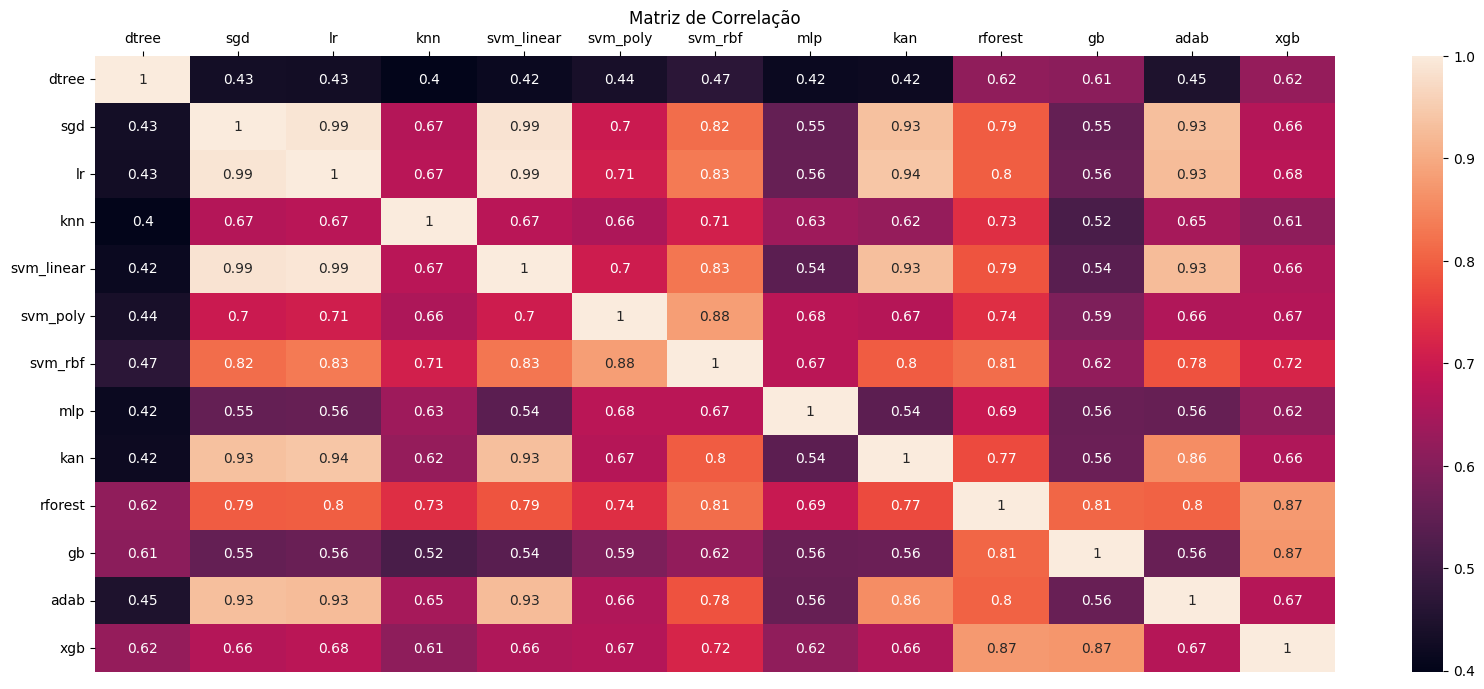

            corr
count  78.000000
mean    0.684102
std     0.153680
min     0.398829
25%     0.562455
50%     0.666920
75%     0.796065
max     0.991096


<Axes: >

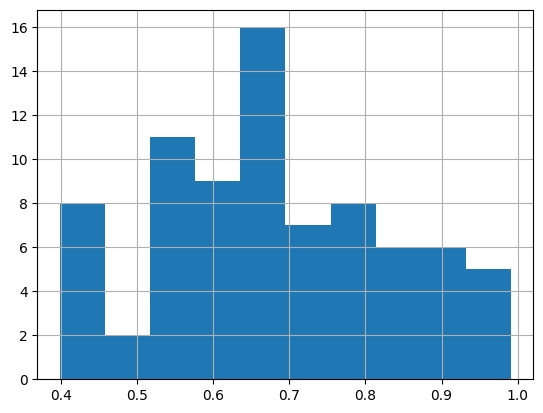

In [251]:
pred_corrls = models_error.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('Matriz de Correlação')
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

corrls_values['corr'].hist()

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [252]:
def group_search_help(df: pd.DataFrame, min_score: int, models: list | set = None, base_group: list = []):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    if len(base_group) == 0:
        base_group, models = models[:1], models[1:]

    output_groups = []

    for m in models:
        check = True
        for bg in base_group:
            corr = df.at[bg, m]
            if np.isnan(corr) or corr < min_score:
                check = False
                break
        if check:
            temp = models.copy()
            temp.remove(m)
            output_groups.append(
                group_search_help(df, min_score, temp, base_group + [m])
            )

    if len(output_groups) == 0:
        return base_group

    return output_groups

def group_search(df: pd.DataFrame, min_score: int, models: list = None):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    # Corrige valores abaixo do min_score
    df = df.map(lambda x: np.nan if x < min_score else x)

    raw_groups = []
    for i in range(len(models)):
        raw_groups.append(group_search_help(df, min_score, models[i:]))

    return remove_subgroups(flatten_groups(raw_groups))
    
def flatten_groups(nested_list):
    flat_list = []

    def _flatten(item):
        if isinstance(item[0], list):
            for subitem in item:
                _flatten(subitem)
        else:
            flat_list.append(sorted(item))  # ordena para facilitar comparação de subconjuntos

    _flatten(nested_list)
    return flat_list

def remove_subgroups(groups:list):
    # Remove duplicatas (grupos com os mesmos elementos, em qualquer ordem)
    seen = set()
    unique_groups = []
    for g in groups:
        frozen = frozenset(g)
        if frozen not in seen:
            seen.add(frozen)
            unique_groups.append(g)

    # Agora removemos subconjuntos estritos
    filtered_groups = []
    for g in unique_groups:
        is_subset = False
        for other in unique_groups:
            if g != other and set(g).issubset(set(other)):
                is_subset = True
                break
        if not is_subset:
            filtered_groups.append(g)

    return filtered_groups

In [253]:
min_score = corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score)

groups['true_assessor_train'] = group_search(pred_corrls, min_score)
groups['true_assessor_train']

Min_score: 0.7960649900605812


[['dtree'],
 ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'svm_rbf'],
 ['adab', 'lr', 'rforest'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [ ]:
def nmse(y_true, y_pred, sample_weight=None, 
         multioutput="uniform_average"):
    mse_error = mse(y_true, y_pred, sample_weight=sample_weight, multioutput="raw_values")
    variance = np.var(np.asarray(y_true), axis=0)
    
    if 0 in variance.flatten():
        raise ValueError("A variância dos valores reais é zero; não é possível normalizar.")
    
    output_errors = mse_error / variance
    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def nmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)    
    error = {}
    for c in y_true.columns:
        error[c] = nmse(y_true[c], y_pred[c])
    return error

def mse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = ((y_true[c] - y_pred[c])**2).mean()
    return error

def rmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (((y_true[c] - y_pred[c])**2).mean())**0.5
    return error

def mae_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (abs(y_true[c] - y_pred[c])).mean()
    return error

In [254]:
models_error

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
0,1.0,0.816066,0.840734,1.000000,0.837717,0.907080,0.903634,7.107275e-01,0.795878,0.42,7.840646e-01,0.551345,0.542966
1,0.0,0.502942,0.506229,0.000000,0.569663,0.525230,0.544435,8.825214e-04,0.625491,0.32,5.766794e-03,0.437586,0.601519
2,1.0,0.568665,0.582332,1.000000,0.546538,0.876562,0.894867,9.999999e-01,0.674331,0.88,9.999856e-01,0.562414,0.997659
3,1.0,0.827625,0.859563,0.762667,0.852293,0.834433,0.888112,9.891538e-01,0.821220,0.78,8.402296e-01,0.602895,0.811739
4,0.0,0.490065,0.506757,0.000000,0.563256,0.182115,0.184304,2.599052e-05,0.452406,0.14,1.210977e-04,0.490118,0.011263
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,1.0,0.306689,0.302497,0.052714,0.273140,0.191714,0.149941,7.333664e-03,0.289434,0.32,1.330470e-02,0.486890,0.093682
2461,0.0,0.545168,0.567090,1.000000,0.640499,0.812219,0.681960,6.027302e-01,0.356724,0.58,2.161152e-02,0.587935,0.144040
2462,0.0,0.000000,0.016748,0.000000,0.014012,0.080252,0.074171,2.509511e-07,0.054629,0.02,2.481207e-07,0.255222,0.014629
2463,0.0,0.054678,0.084386,0.000000,0.068813,0.209176,0.104396,2.074152e-04,0.119742,0.00,3.852029e-07,0.289182,0.000681


In [255]:
#model_names = list(performs.keys())

Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
0,1.0,0.816066,0.840734,1.000000,0.837717,0.907080,0.903634,0.710727,0.795878,0.42,0.784065,0.551345,0.542966
1,0.0,0.502942,0.506229,0.000000,0.569663,0.525230,0.544435,0.000883,0.625491,0.32,0.005767,0.437586,0.601519
2,1.0,0.568665,0.582332,1.000000,0.546538,0.876562,0.894867,1.000000,0.674331,0.88,0.999986,0.562414,0.997659
3,1.0,0.827625,0.859563,0.762667,0.852293,0.834433,0.888112,0.989154,0.821220,0.78,0.840230,0.602895,0.811739
4,0.0,0.490065,0.506757,0.000000,0.563256,0.182115,0.184304,0.000026,0.452406,0.14,0.000121,0.490118,0.011263


In [256]:
Xa_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3994,1,1,0,0,23,1,2,2,1,1,2,1,1,1,0,1,2,79.35,1835.30
2629,1,0,0,0,5,1,1,1,1,2,1,1,1,1,0,0,1,50.55,244.75
732,0,0,0,0,17,1,1,1,1,1,1,2,1,1,0,0,2,51.50,900.50
2970,1,0,0,0,5,1,2,2,1,1,2,2,1,1,0,1,3,82.75,417.75
1342,1,0,0,0,15,1,1,1,1,2,1,1,1,1,0,0,3,48.85,736.80


In [257]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
0,0.0,0.141922,0.101620,0.000000,0.117275,0.134259,0.156307,0.883674,0.240909,0.02,0.000029,0.304206,0.006569
1,1.0,0.121427,0.111948,0.000000,0.128655,0.168696,0.185578,0.363394,0.174968,0.34,0.981957,0.368080,0.472621
2,1.0,0.823291,0.841404,1.000000,0.844831,0.999517,0.965199,0.987933,0.841956,0.92,0.999988,0.605309,0.977660
3,0.0,0.133640,0.124236,0.252403,0.161239,0.219065,0.171739,0.000593,0.145484,0.08,0.004287,0.368080,0.034872
4,0.0,0.216827,0.178295,0.000000,0.177934,0.168973,0.154507,0.000400,0.151761,0.00,0.000002,0.345767,0.010851


In [258]:
Xa_test_norm

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,1,1,0,0,0.013889,0,0,1,1,1,1,1,2,1,0,1,3,0.181365,0.004197
1,0,0,0,0,0.208333,1,2,2,1,1,1,1,2,2,0,1,3,0.748381,0.166342
2,0,0,1,0,0.680556,1,2,1,2,1,2,2,2,2,1,0,3,0.658695,0.467409
3,1,0,0,0,0.069444,1,1,2,1,2,1,1,2,2,0,1,3,0.777280,0.059005
4,1,0,0,0,0.013889,1,1,2,1,1,1,1,1,1,0,0,2,0.524664,0.008164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,0,0,1,1,0.152778,1,1,1,1,1,2,1,2,1,0,1,1,0.412556,0.078672
2110,0,0,0,0,0.361111,1,1,1,1,1,1,2,1,1,0,0,1,0.307922,0.142467
2111,0,0,0,0,0.263889,1,1,1,1,1,1,1,1,1,0,1,1,0.266567,0.099697
2112,0,0,0,1,0.986111,1,2,0,0,0,0,0,0,0,2,0,2,0.060787,0.190517


In [259]:
ya_test

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
0,0.0,0.141922,0.101620,0.000000,0.117275,0.134259,0.156307,8.836736e-01,0.240909,0.02,2.906045e-05,0.304206,0.006569
1,1.0,0.121427,0.111948,0.000000,0.128655,0.168696,0.185578,3.633943e-01,0.174968,0.34,9.819574e-01,0.368080,0.472621
2,1.0,0.823291,0.841404,1.000000,0.844831,0.999517,0.965199,9.879332e-01,0.841956,0.92,9.999885e-01,0.605309,0.977660
3,0.0,0.133640,0.124236,0.252403,0.161239,0.219065,0.171739,5.929268e-04,0.145484,0.08,4.286847e-03,0.368080,0.034872
4,0.0,0.216827,0.178295,0.000000,0.177934,0.168973,0.154507,4.001364e-04,0.151761,0.00,2.223039e-06,0.345767,0.010851
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,0.0,0.492191,0.466229,0.000000,0.521271,0.204994,0.114729,2.237100e-05,0.451364,0.10,1.902342e-04,0.457019,0.020565
2110,0.0,0.371434,0.317314,0.291378,0.381927,0.130506,0.061143,1.109268e-08,0.258788,0.14,2.854126e-05,0.414330,0.006987
2111,0.0,0.497809,0.479111,0.376848,0.540146,0.566417,0.505639,1.873916e-02,0.405034,0.36,4.606977e-03,0.454123,0.048635
2112,0.0,0.000000,0.011566,0.000000,0.009737,0.118894,0.053248,2.974686e-07,0.040745,0.02,8.231112e-07,0.222851,0.001839


#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

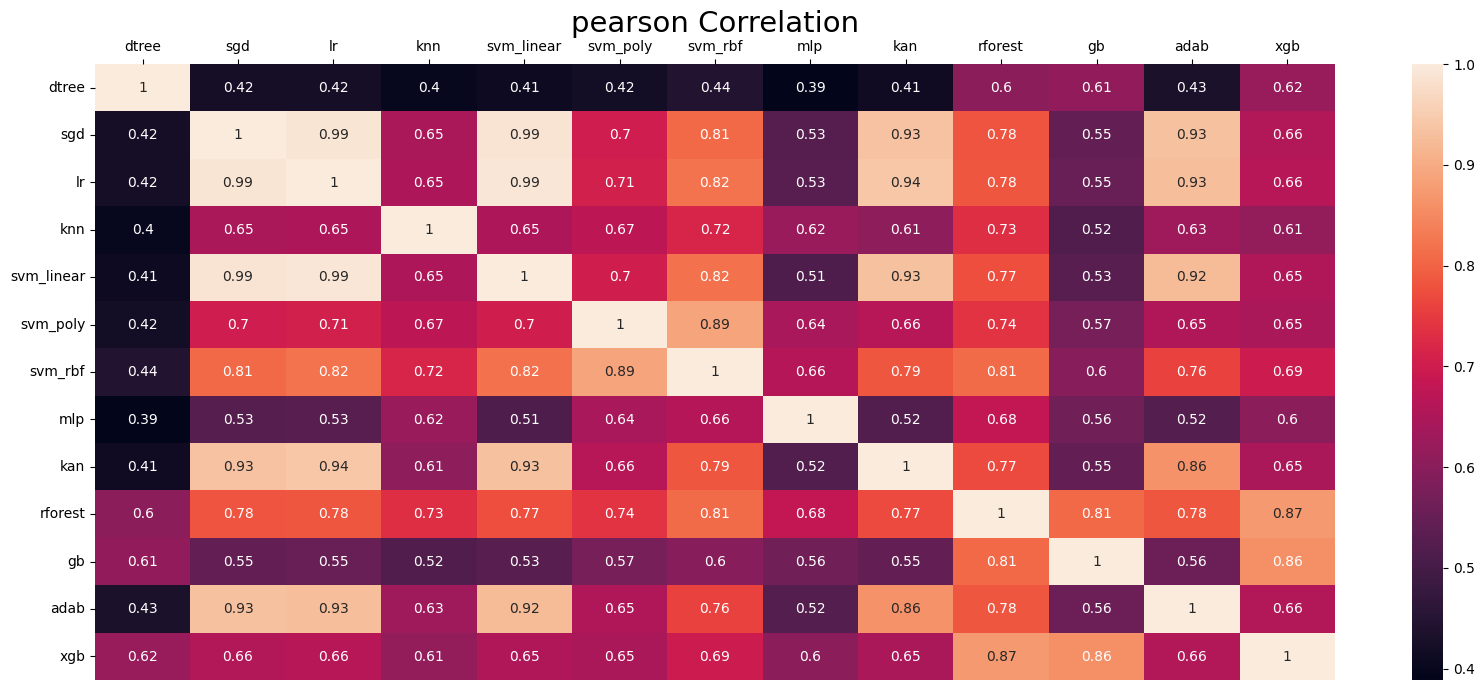

count    78.000000
mean      0.675017
std       0.157746
min       0.388644
25%       0.558791
50%       0.655067
75%       0.784227
max       0.991332
Name: corr, dtype: float64


<Axes: >

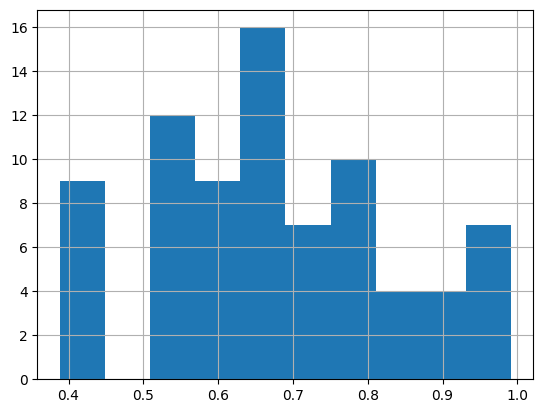

In [280]:
pred_corrls2 = ya_test.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

corrls_values2.hist()

In [281]:
min_score2 = corrls_values2.quantile(0.75)

print('Min_score:', min_score2)

groups['true_assessor_test'] = group_search(pred_corrls2, min_score2)
groups['true_assessor_test']

Min_score: 0.7842266884142243


[['dtree'],
 ['kan', 'lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['rforest', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb'],
 ['adab', 'rforest']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0002
NMSE: 0.0138
MAE: 0.0106
NMSE: 0.0081
Desvio Padrão: 0.0105


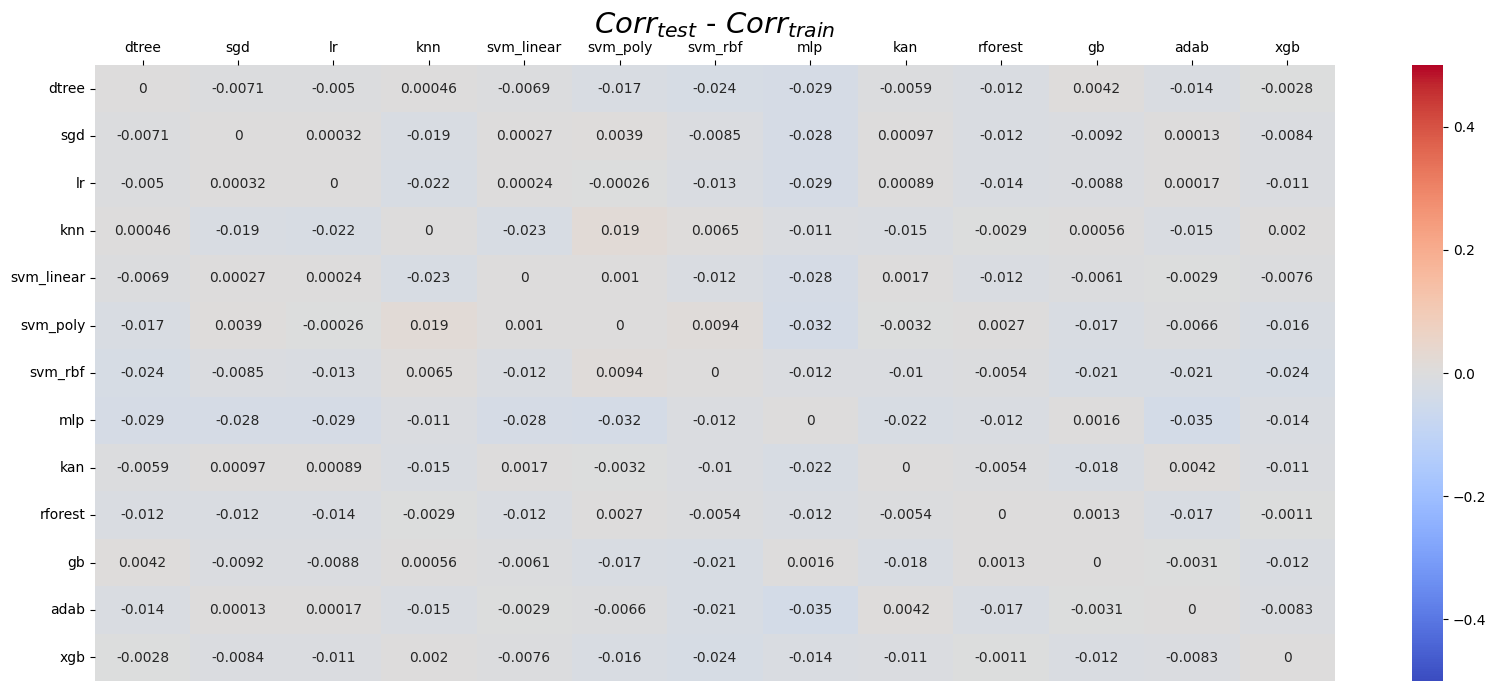

In [ ]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Globais

### Regressor Chain
(RC)

In [ ]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.6s
[Chain] .................. (2 of 13) Processing order 1, total=   0.9s
[Chain] .................. (3 of 13) Processing order 2, total=   1.2s
[Chain] .................. (4 of 13) Processing order 3, total=   1.2s
[Chain] .................. (5 of 13) Processing order 4, total=   1.6s
[Chain] .................. (6 of 13) Processing order 5, total=   1.8s
[Chain] .................. (7 of 13) Processing order 6, total=   2.0s
[Chain] .................. (8 of 13) Processing order 7, total=   2.3s
[Chain] .................. (9 of 13) Processing order 8, total=   2.3s
[Chain] ................. (10 of 13) Processing order 9, total=   2.4s
[Chain] ................ (11 of 13) Processing order 10, total=   3.0s
[Chain] ................ (12 of 13) Processing order 11, total=   2.7s
[Chain] ................ (13 of 13) Processing order 12, total=   3.5s


In [ ]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [ ]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0752
RMSE: 0.2589
MAE: 0.1924


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.178037,0.033546,0.04091,0.113667,0.039202,0.068335,0.062807,0.132786,0.03486,0.046681,0.128486,0.007077,0.090683
multi-output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

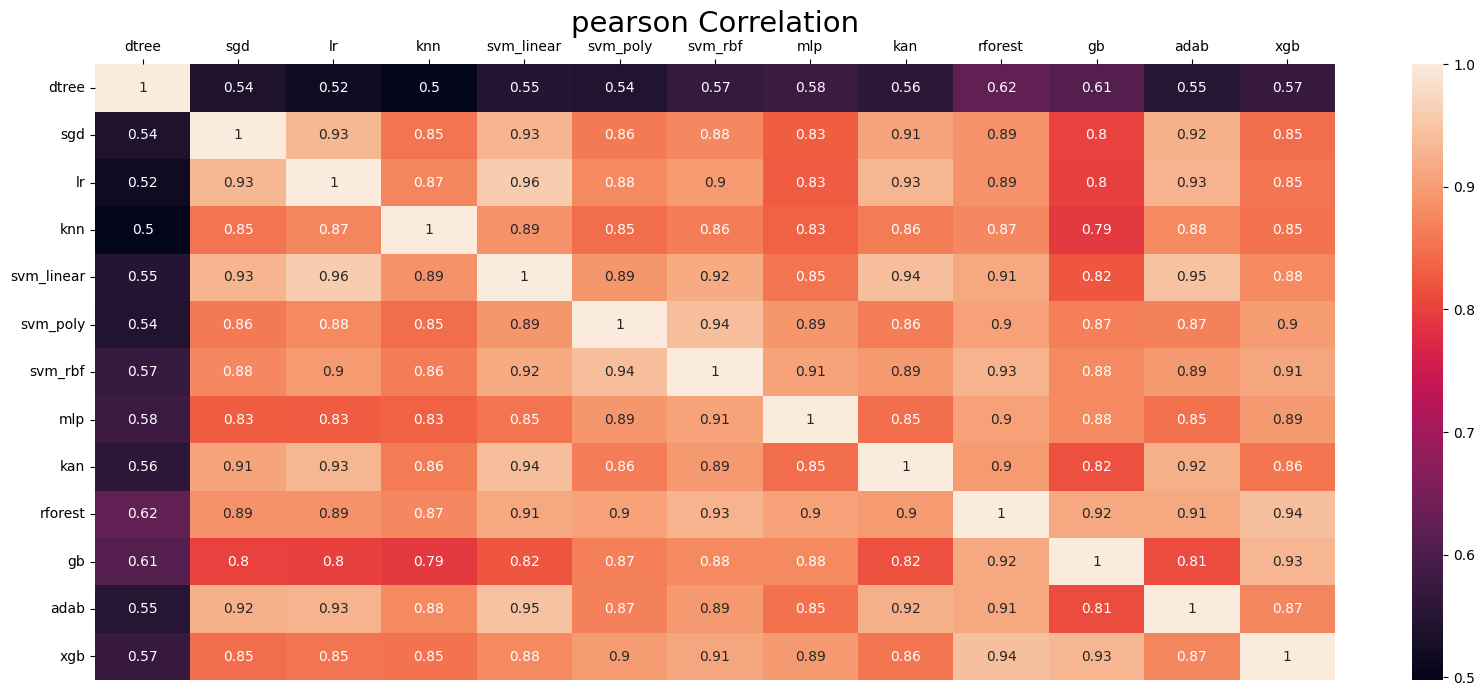

count    78.000000
mean      0.832457
std       0.123516
min       0.497831
25%       0.830630
50%       0.875602
75%       0.906300
max       0.958569
Name: corr, dtype: float64


<Axes: >

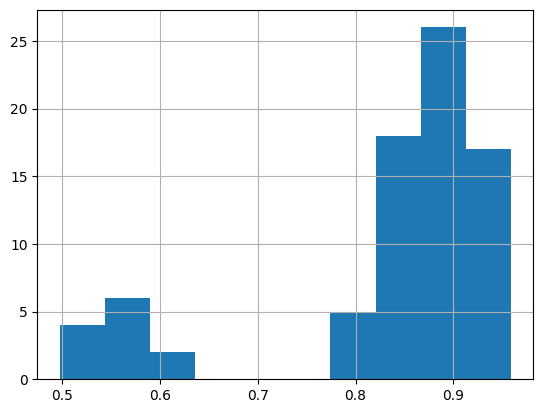

In [268]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('pearson') 

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

regchain_corrls_values.hist()

In [269]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_train'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_train']

Min_score: 0.9063001703239006


[['dtree'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['knn'],
 ['rforest', 'svm_linear', 'svm_rbf'],
 ['adab', 'rforest', 'svm_linear'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'svm_rbf'],
 ['rforest', 'svm_rbf', 'xgb'],
 ['gb', 'rforest', 'xgb']]

Conjunto de Teste:

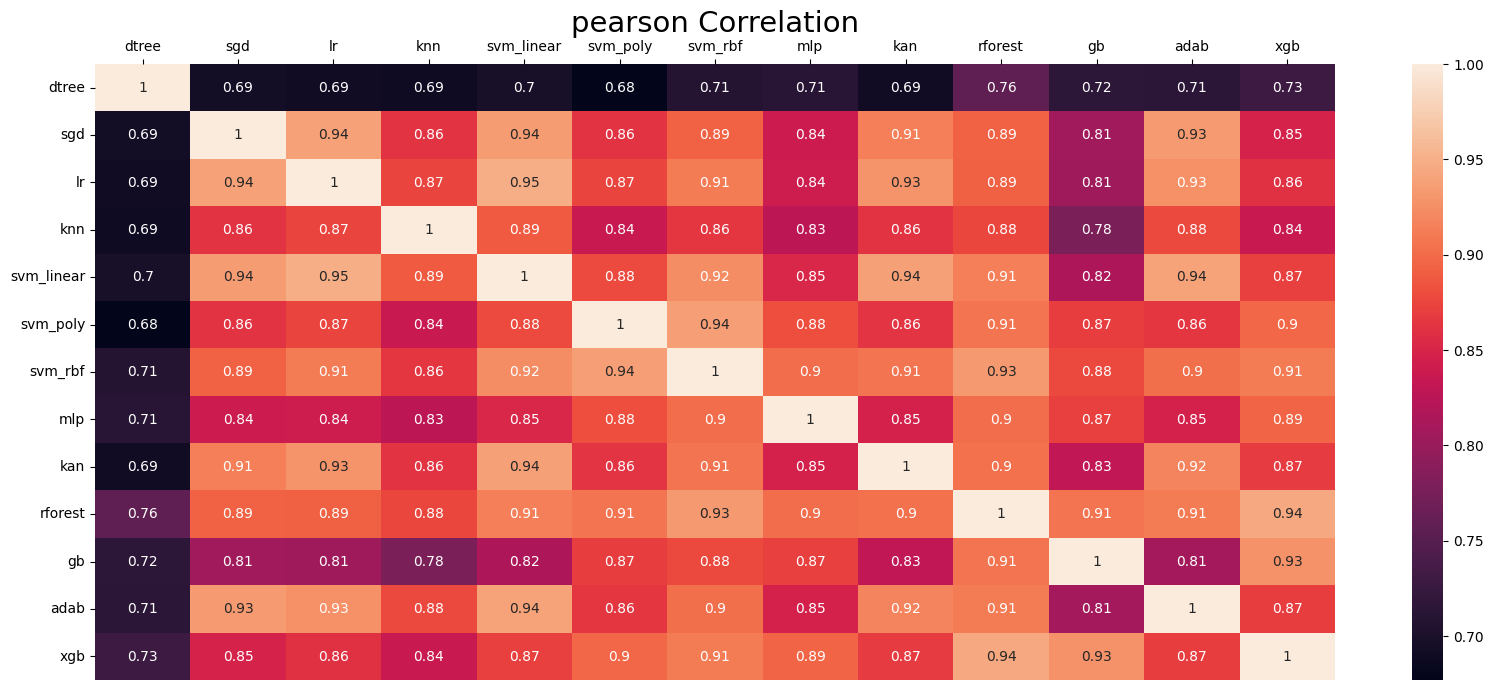

count    78.000000
mean      0.855514
std       0.074055
min       0.676956
25%       0.836605
50%       0.873016
75%       0.906289
max       0.948401
Name: corr, dtype: float64


<Axes: >

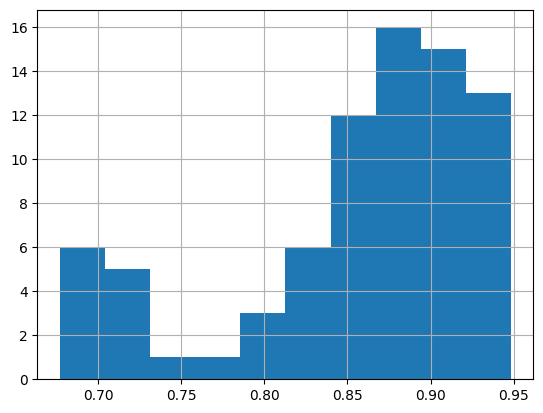

In [270]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

regchain_corrls_values.hist()

In [271]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_test'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_test']

Min_score: 0.9062892385650934


[['dtree'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['kan', 'lr', 'svm_linear', 'svm_rbf'],
 ['knn'],
 ['rforest', 'svm_linear', 'svm_rbf'],
 ['adab', 'rforest', 'svm_linear'],
 ['svm_poly', 'svm_rbf'],
 ['rforest', 'svm_rbf', 'xgb'],
 ['mlp'],
 ['gb', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0430
RMSE: 0.2073
MAE: 0.1851
NMSE: 1.7277
Desvio Padrão: 0.1027


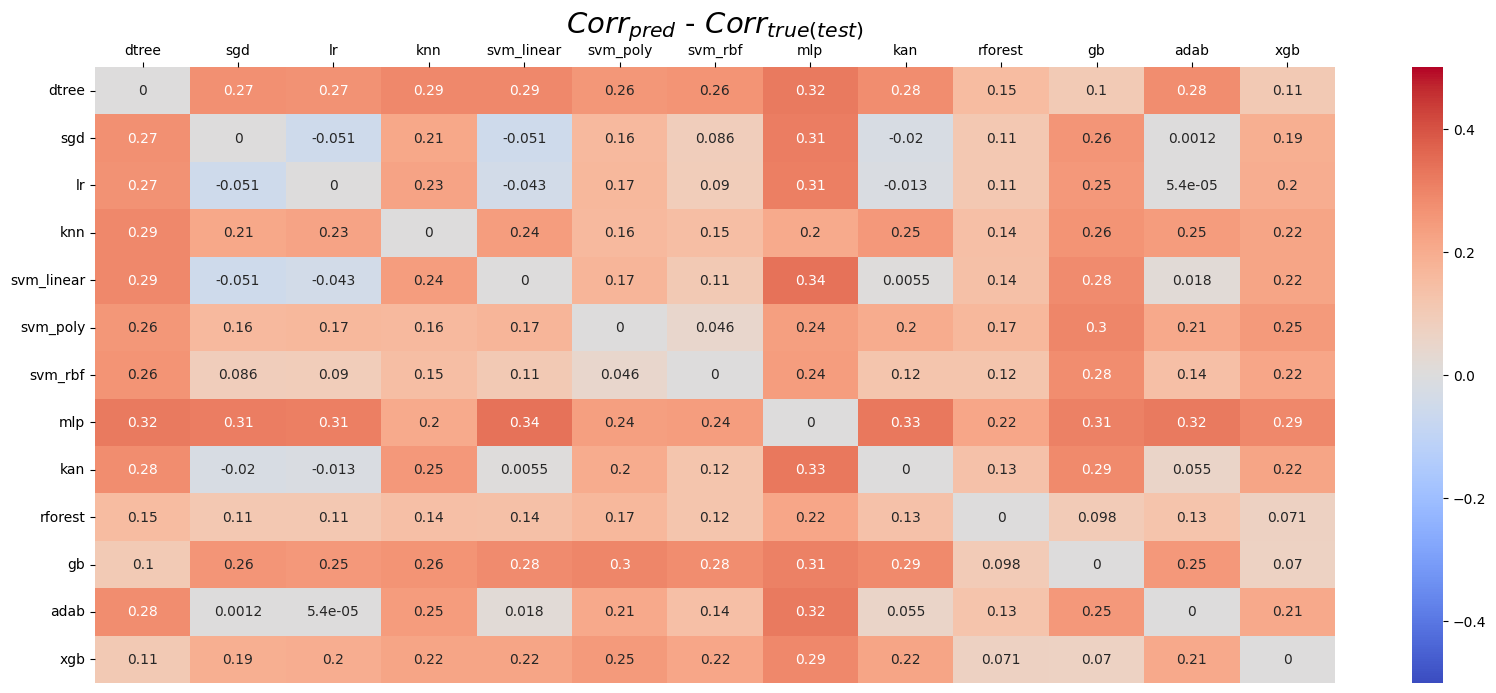

In [261]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

### Multi-Output Regressor 
(ST)

In [ ]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [ ]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0762
RMSE: 0.2608
MAE: 0.1879


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.178037,0.033546,0.040910,0.113667,0.039202,0.068335,0.062807,0.132786,0.034860,0.046681,0.128486,0.007077,0.090683
multi-output,0.178037,0.034438,0.040237,0.116835,0.039294,0.071064,0.063544,0.136825,0.035089,0.048856,0.127563,0.007290,0.091512
individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Análise das correlações

Conjunto de Treinamento:

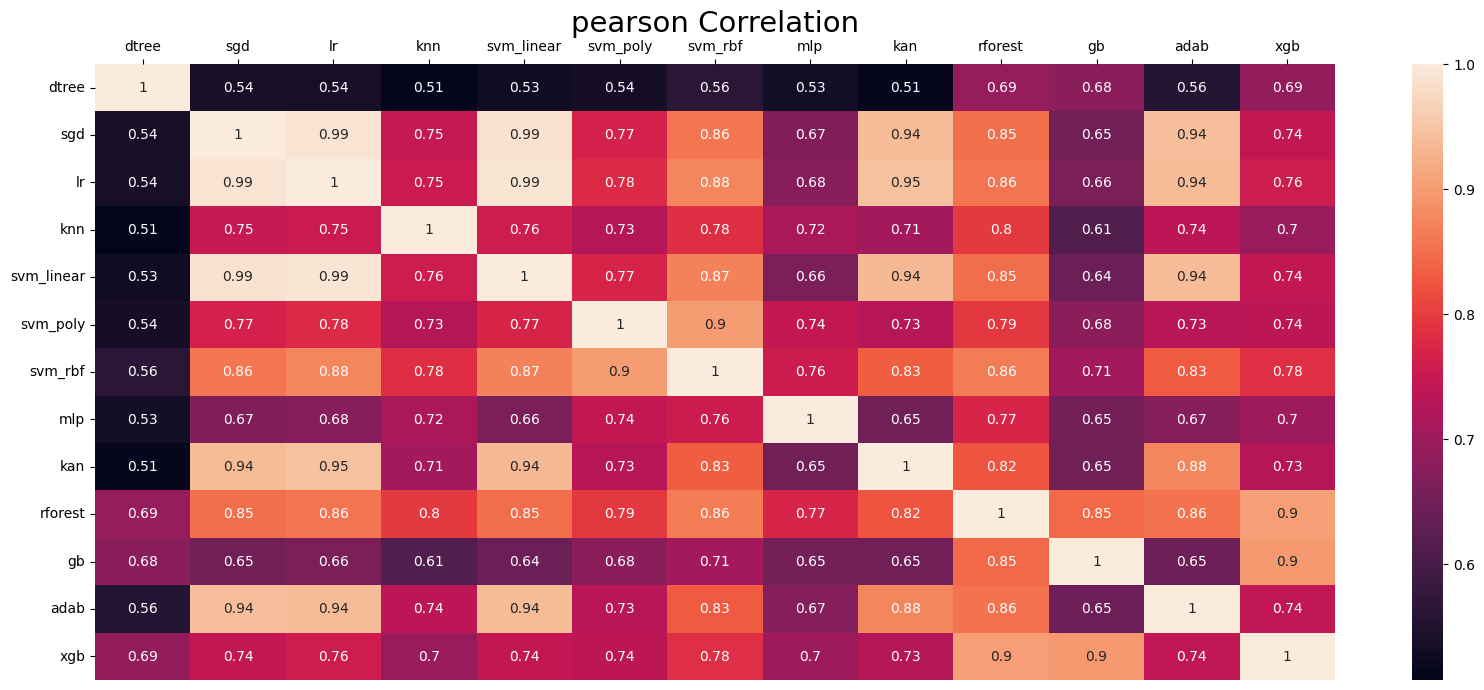

count    78.000000
mean      0.752590
std       0.123040
min       0.507499
25%       0.674438
50%       0.743004
75%       0.849684
max       0.990627
Name: corr, dtype: float64


<Axes: >

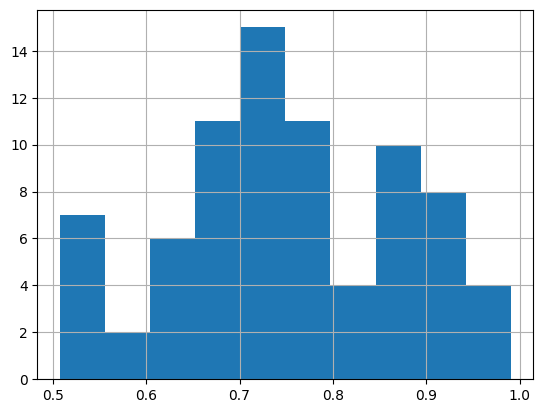

In [272]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('pearson')

plt.figure(figsize=(20,8))
plt.title(r'pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

mor_corrls_values.hist()

In [273]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_train'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_train']

Min_score: 0.8496840448518959


[['dtree'],
 ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'sgd', 'svm_rbf'],
 ['adab', 'lr', 'rforest', 'sgd'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['rforest', 'xgb'],
 ['gb', 'xgb']]

Conjunto de Teste:

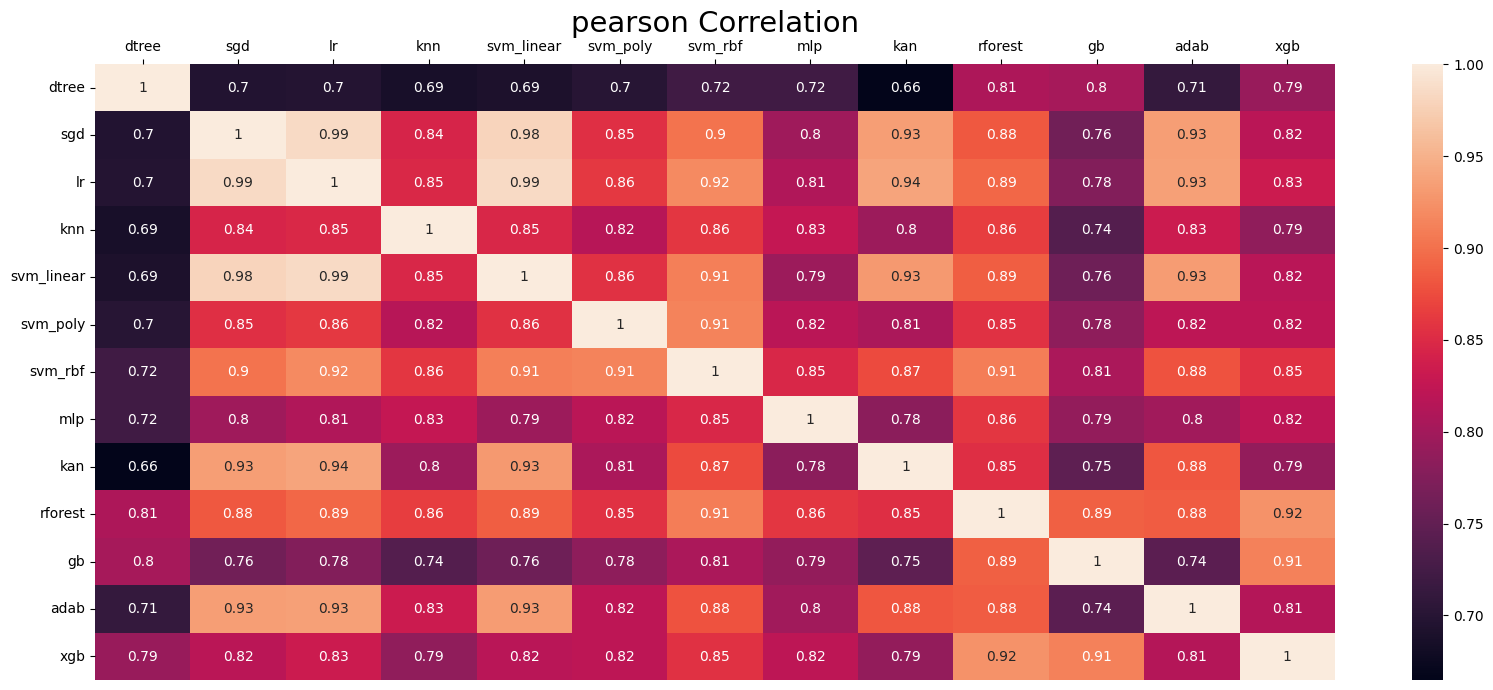

count    78.000000
mean      0.832210
std       0.074386
min       0.664900
25%       0.789717
50%       0.829398
75%       0.884451
max       0.985173
Name: corr, dtype: float64


<Axes: >

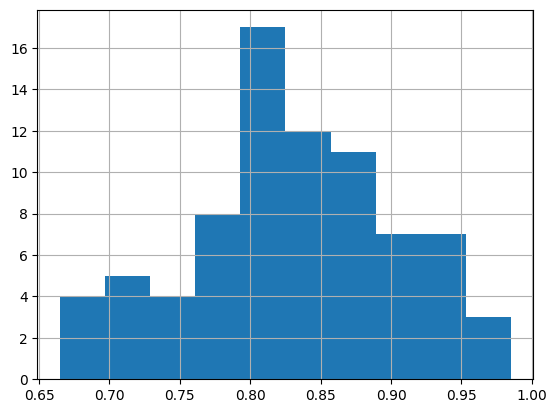

In [ ]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

mor_corrls_values.hist()

In [275]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_test'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_test']

Min_score: 0.8844512868827383


[['dtree'],
 ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'lr', 'sgd', 'svm_linear'],
 ['adab', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'svm_linear', 'svm_rbf'],
 ['adab', 'lr', 'rforest', 'svm_linear'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0323
RMSE: 0.1797
MAE: 0.1578
NMSE: 1.2974
Desvio Padrão: 0.0876


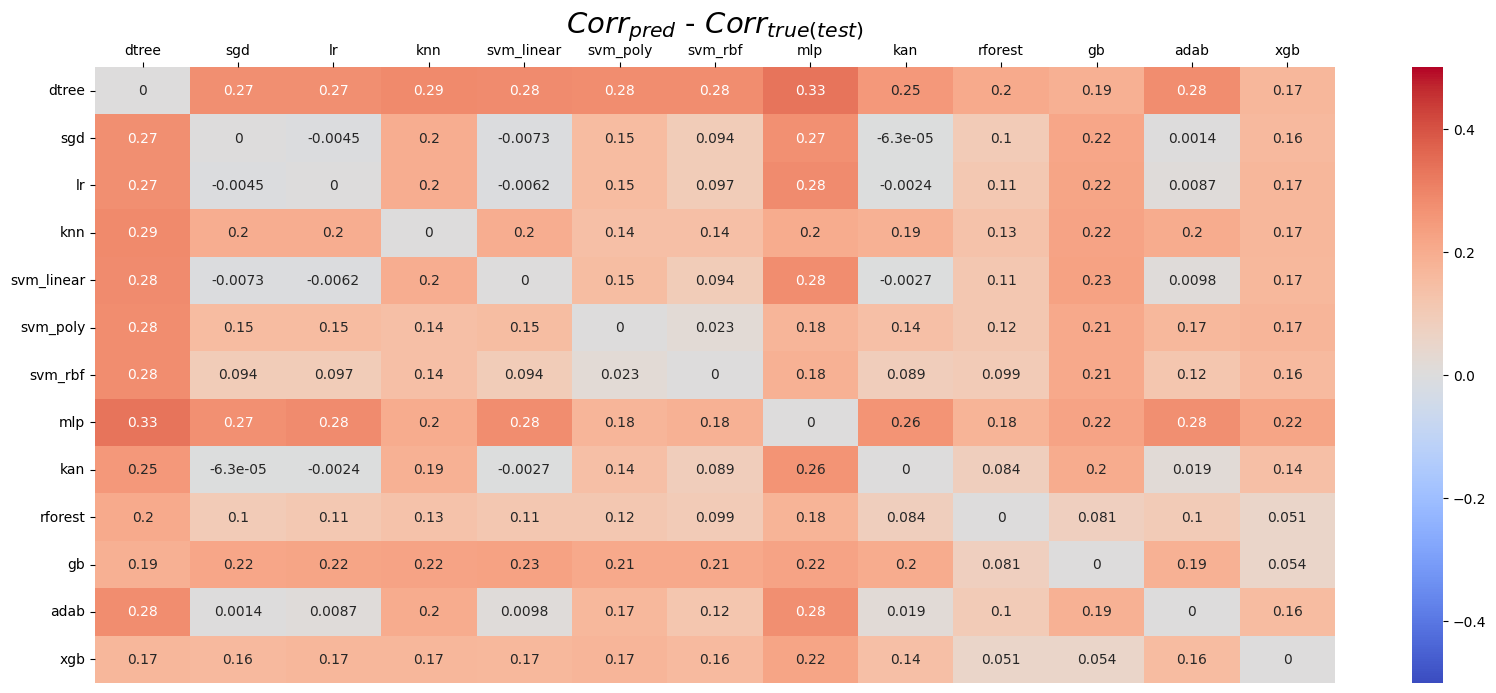

In [260]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = mor_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Individuais

In [128]:
ind_assessors = {}
parameters['criterion'] = ['squared_error', 'poisson', 'friedman_mse']

for i in range(len(models)):
    g_search = GridSearchCV(RandomForestRegressor(random_state=seed), parameters, cv=5, n_jobs=-1)
    ind_assessors[model_names[i]] = g_search.fit(Xa_train, ya_train[model_names[i]]).best_estimator_
    print(f'[Assessor {i}] | Modelo Base: {model_names[i]} | Parâmetros: {g_search.best_params_}\nScore: {g_search.best_score_:.4f}\n')

[Assessor 0] | Modelo Base: dtree | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.1264

[Assessor 1] | Modelo Base: sgd | Parâmetros: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Score: 0.5322

[Assessor 2] | Modelo Base: lr | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 50}
Score: 0.4623

[Assessor 3] | Modelo Base: knn | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 50}
Score: 0.2254

[Assessor 4] | Modelo Base: svm_linear | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 20}
Score: 0.4836

[Assessor 5] | Modelo Base: svm_poly | Parâmetros: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_le

In [129]:
metrics_indv = {'MSE':[], 'RMSE':[], 'MAE':[], 'NMSE':[]}

for m in model_names:
    y_pred = ind_assessors[m].predict(Xa_test)

    # Cálculo das métricas
    metrics_indv['MSE'].append(mse(ya_test[m], y_pred))
    metrics_indv['RMSE'].append(rmse(ya_test[m], y_pred))
    metrics_indv['MAE'].append(mae(ya_test[m], y_pred))
    metrics_indv['NMSE'].append(nmse(ya_test[m], y_pred))


    mse_df.at['individual',m] = mse(ya_test[m], y_pred)
    rmse_df.at['individual',m] = rmse(ya_test[m], y_pred)
    mae_df.at['individual',m] = mae(ya_test[m], y_pred)
    nmse_df.at['individual',m] = nmse(ya_test[m], y_pred)

for k in metrics_indv.keys():
    print(f'''{k}:
    - Média: {np.mean(metrics_indv[k]):.4f}
    - DP:    {np.std(metrics_indv[k]):.4f}''')

mse_df

MSE:
    - Média: 0.0716
    - DP:    0.0460
RMSE:
    - Média: 0.2526
    - DP:    0.0884
MAE:
    - Média: 0.1868
    - DP:    0.0778
NMSE:
    - Média: 0.6730
    - DP:    0.1313


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.178037,0.033546,0.040910,0.113667,0.039202,0.068335,0.062807,0.132786,0.034860,0.046681,0.128486,0.007077,0.090683
multi-output,0.178037,0.034438,0.040237,0.116835,0.039294,0.071064,0.063544,0.136825,0.035089,0.048856,0.127563,0.007290,0.091512
individual,0.172037,0.032433,0.037757,0.108768,0.036211,0.066569,0.059506,0.126065,0.033023,0.045570,0.120655,0.006783,0.085556


#### Análise das correlações

Conjunto de Treinamento:

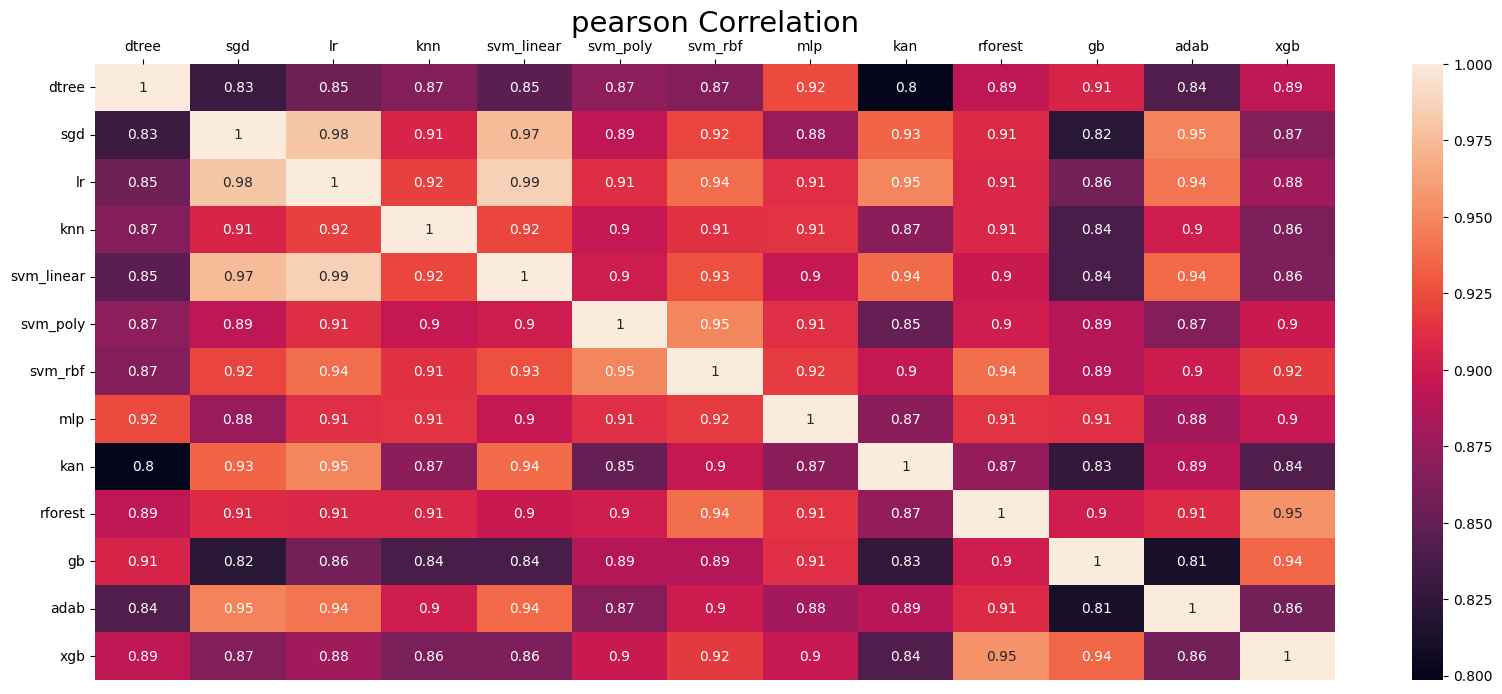

count    78.000000
mean      0.895360
std       0.038786
min       0.798615
25%       0.866763
50%       0.899008
75%       0.917742
max       0.985723
Name: corr, dtype: float64


<Axes: >

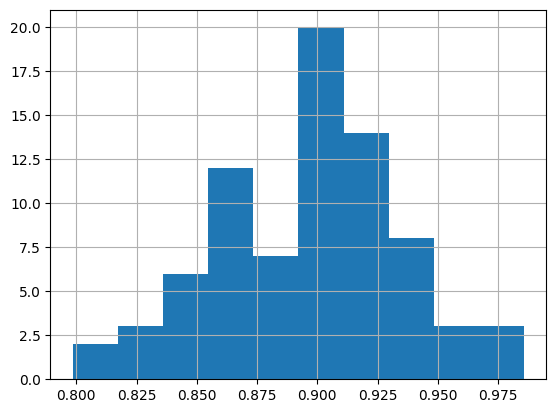

In [276]:
#y_pred = pd.DataFrame(columns=model_names)

indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_train.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_train)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

indass_corrls_values = corrlArray(indass_corrls)['corr']
print(indass_corrls_values.describe())

indass_corrls_values.hist()

In [277]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_train'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_train']

Min_score: 0.9177423587794828


[['dtree', 'mlp'],
 ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'lr', 'sgd', 'svm_linear'],
 ['adab', 'lr', 'sgd', 'svm_linear'],
 ['knn', 'lr', 'svm_linear'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'svm_rbf'],
 ['rforest', 'svm_rbf'],
 ['rforest', 'xgb'],
 ['gb', 'xgb']]

Conjunto de Teste:

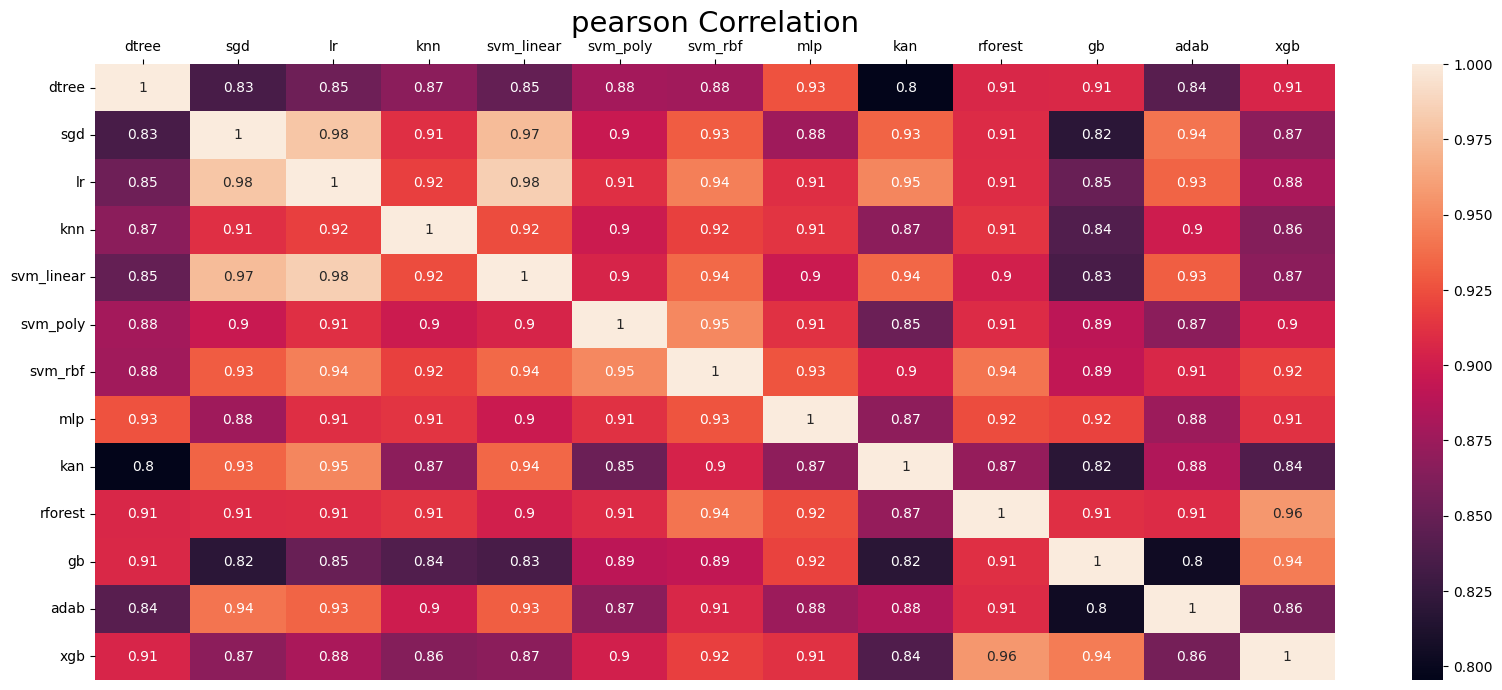

count    78.000000
mean      0.897117
std       0.039724
min       0.795460
25%       0.867817
50%       0.905731
75%       0.922926
max       0.984772
Name: corr, dtype: float64


<Axes: >

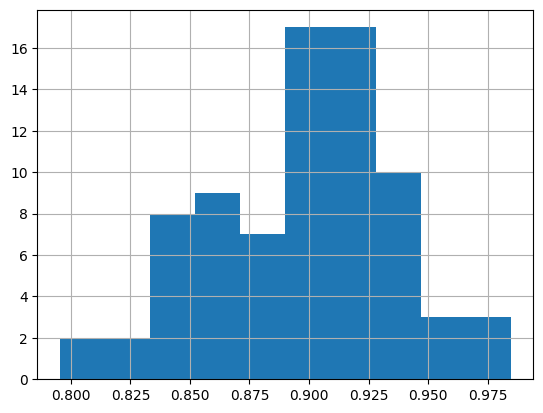

In [278]:
indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_test.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_test)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

indass_corrls_values = corrlArray(indass_corrls)['corr']
print(indass_corrls_values.describe())

indass_corrls_values.hist()

In [279]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_test'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_test']

Min_score: 0.922925963475473


[['dtree', 'mlp'],
 ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'lr', 'sgd', 'svm_linear'],
 ['adab', 'lr', 'sgd', 'svm_linear'],
 ['knn', 'svm_linear'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'rforest', 'svm_rbf'],
 ['rforest', 'xgb'],
 ['gb', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0664
RMSE: 0.2576
MAE: 0.2228
NMSE: 2.6669
Desvio Padrão: 0.1314


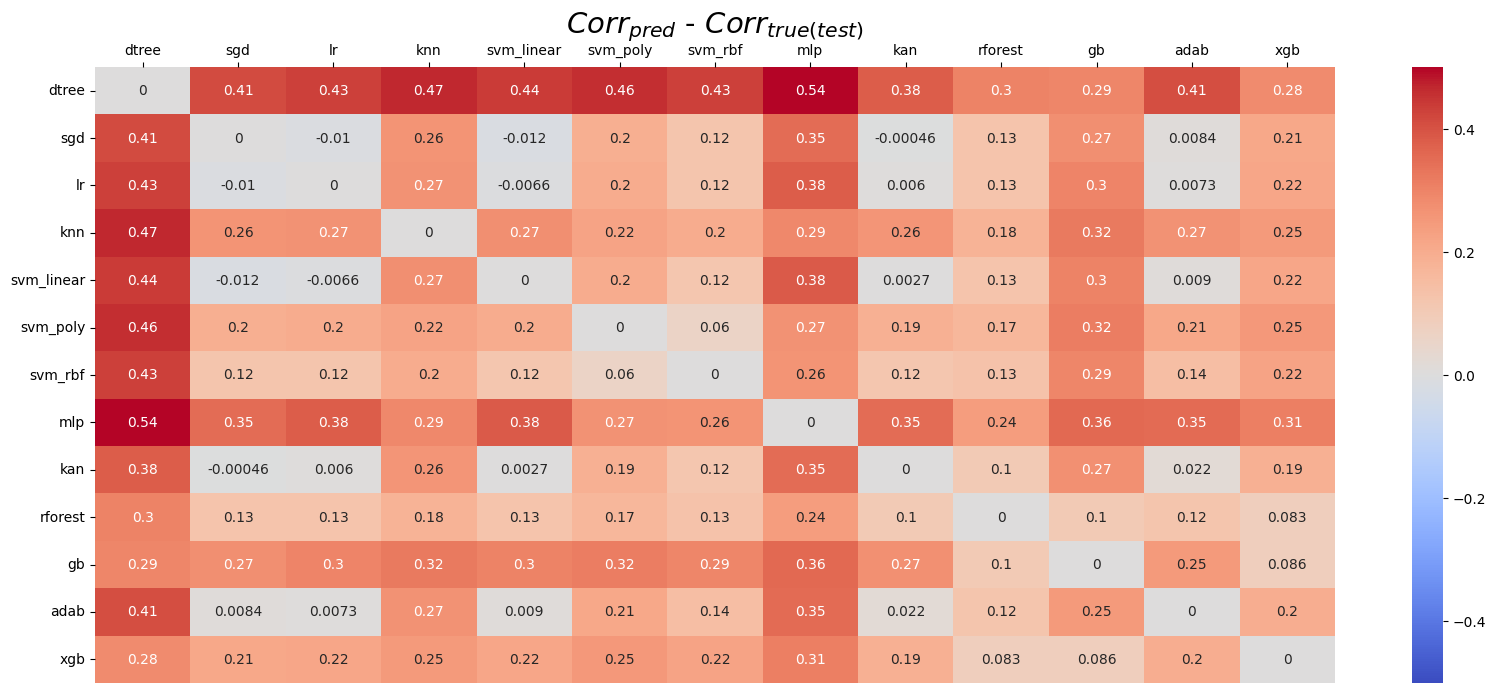

<Axes: >

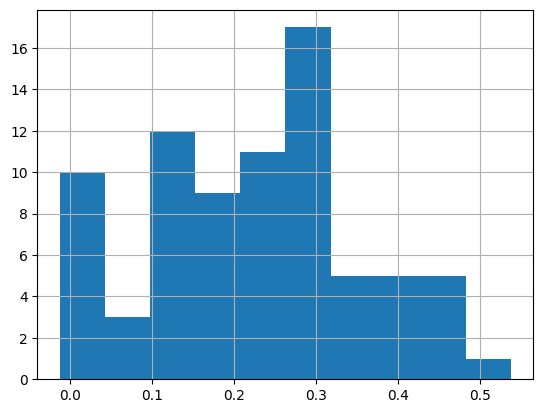

In [267]:
#pred_corrls2 = ya_test.corr('pearson')
diff_corrls = indass_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls_values.hist()

## Grupais

In [139]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(9) & true_assessor_test(8):
['dtree']
['adab', 'kan', 'lr', 'sgd', 'svm_linear']
['knn']
['svm_poly', 'svm_rbf']
['mlp']
Número de grupos em comum: 5


true_assessor_train(9) & regchain_assessor_train(9):
['dtree']
['knn']
['svm_poly', 'svm_rbf']
['mlp']
['gb', 'rforest', 'xgb']
Número de grupos em comum: 5


true_assessor_train(9) & regchain_assessor_test(9):
['dtree']
['adab', 'kan', 'lr', 'sgd', 'svm_linear']
['knn']
['svm_poly', 'svm_rbf']
['mlp']
Número de grupos em comum: 5


true_assessor_train(9) & mor_assessor_train(8):
['dtree']
['adab', 'kan', 'lr', 'sgd', 'svm_linear']
['knn']
['svm_poly', 'svm_rbf']
['mlp']
Número de grupos em comum: 5


true_assessor_train(9) & mor_assessor_test(10):
['dtree']
['knn']
['svm_poly', 'svm_rbf']
['mlp']
Número de grupos em comum: 4


true_assessor_train(9) & indv_assessor_train(10):
['dtree']
['knn']
['svm_poly', 'svm_rbf']
['mlp']
Número de grupos em comum: 4


true_assessor_train(9) & indv_assessor_test(10):
['dtree']
['

In [140]:
pred_corrls

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
dtree,1.000000,0.429592,0.428303,0.398829,0.415318,0.436795,0.467760,0.417405,0.418839,0.616113,0.608506,0.447412,0.623760
sgd,0.429592,1.000000,0.989352,0.666529,0.986450,0.697314,0.815446,0.554262,0.933127,0.794351,0.554410,0.931783,0.664639
lr,0.428303,0.989352,1.000000,0.671536,0.991096,0.708327,0.833247,0.558237,0.941185,0.796387,0.561724,0.926124,0.675049
knn,0.398829,0.666529,0.671536,1.000000,0.672599,0.655262,0.709955,0.634523,0.623074,0.734777,0.515537,0.646065,0.612724
svm_linear,0.415318,0.986450,0.991096,0.672599,1.000000,0.702357,0.828566,0.542063,0.930590,0.785245,0.537955,0.925070,0.659007
svm_poly,0.436795,0.697314,0.708327,0.655262,0.702357,1.000000,0.880364,0.675113,0.667298,0.735617,0.591185,0.660542,0.665171
svm_rbf,0.467760,0.815446,0.833247,0.709955,0.828566,0.880364,1.000000,0.673705,0.795099,0.814904,0.618462,0.782286,0.718381
mlp,0.417405,0.554262,0.558237,0.634523,0.542063,0.675113,0.673705,1.000000,0.542122,0.694501,0.562146,0.558074,0.616209
kan,0.418839,0.933127,0.941185,0.623074,0.930590,0.667298,0.795099,0.542122,1.000000,0.774331,0.563383,0.857995,0.659211
rforest,0.616113,0.794351,0.796387,0.734777,0.785245,0.735617,0.814904,0.694501,0.774331,1.000000,0.806621,0.801343,0.874389


In [141]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['lr', 'sgd', 'svm_linear', 'svm_rbf']
total: 0.9073592801669773

['adab', 'kan', 'lr', 'sgd', 'svm_linear']
total: 0.9412771410711344

['lr', 'rforest', 'svm_rbf']
total: 0.8148458472635699

['adab', 'lr', 'rforest']
total: 0.8412845507452192

['svm_poly', 'svm_rbf']
total: 0.8803636801727596

['gb', 'rforest', 'xgb']
total: 0.8503911925645279



In [142]:
groups

{'true_assessor_train': [['dtree'],
  ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
  ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
  ['lr', 'rforest', 'svm_rbf'],
  ['adab', 'lr', 'rforest'],
  ['knn'],
  ['svm_poly', 'svm_rbf'],
  ['mlp'],
  ['gb', 'rforest', 'xgb']],
 'true_assessor_test': [['dtree'],
  ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
  ['lr', 'svm_linear', 'svm_rbf'],
  ['knn'],
  ['svm_poly', 'svm_rbf'],
  ['mlp'],
  ['rforest', 'xgb'],
  ['gb', 'xgb']],
 'regchain_assessor_train': [['dtree'],
  ['adab', 'lr', 'sgd', 'svm_linear'],
  ['adab', 'kan', 'lr', 'svm_linear'],
  ['knn'],
  ['svm_linear', 'svm_rbf'],
  ['svm_poly', 'svm_rbf'],
  ['rforest', 'svm_rbf'],
  ['mlp'],
  ['gb', 'rforest', 'xgb']],
 'regchain_assessor_test': [['dtree'],
  ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
  ['knn'],
  ['svm_linear', 'svm_rbf'],
  ['svm_poly', 'svm_rbf'],
  ['rforest', 'svm_rbf'],
  ['mlp'],
  ['rforest', 'xgb'],
  ['gb', 'xgb']],
 'mor_assessor_train': [['dtree'],
  ['adab', 'kan',

In [143]:
groups['true_assessor_train']

[['dtree'],
 ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'svm_rbf'],
 ['adab', 'lr', 'rforest'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

In [144]:
groups['true_assessor_test']

[['dtree'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'svm_linear', 'svm_rbf'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['rforest', 'xgb'],
 ['gb', 'xgb']]

### Regressor Chain

In [145]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [146]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0755
RMSE: 0.2590
MAE: 0.1894
NMSE: 0.7078


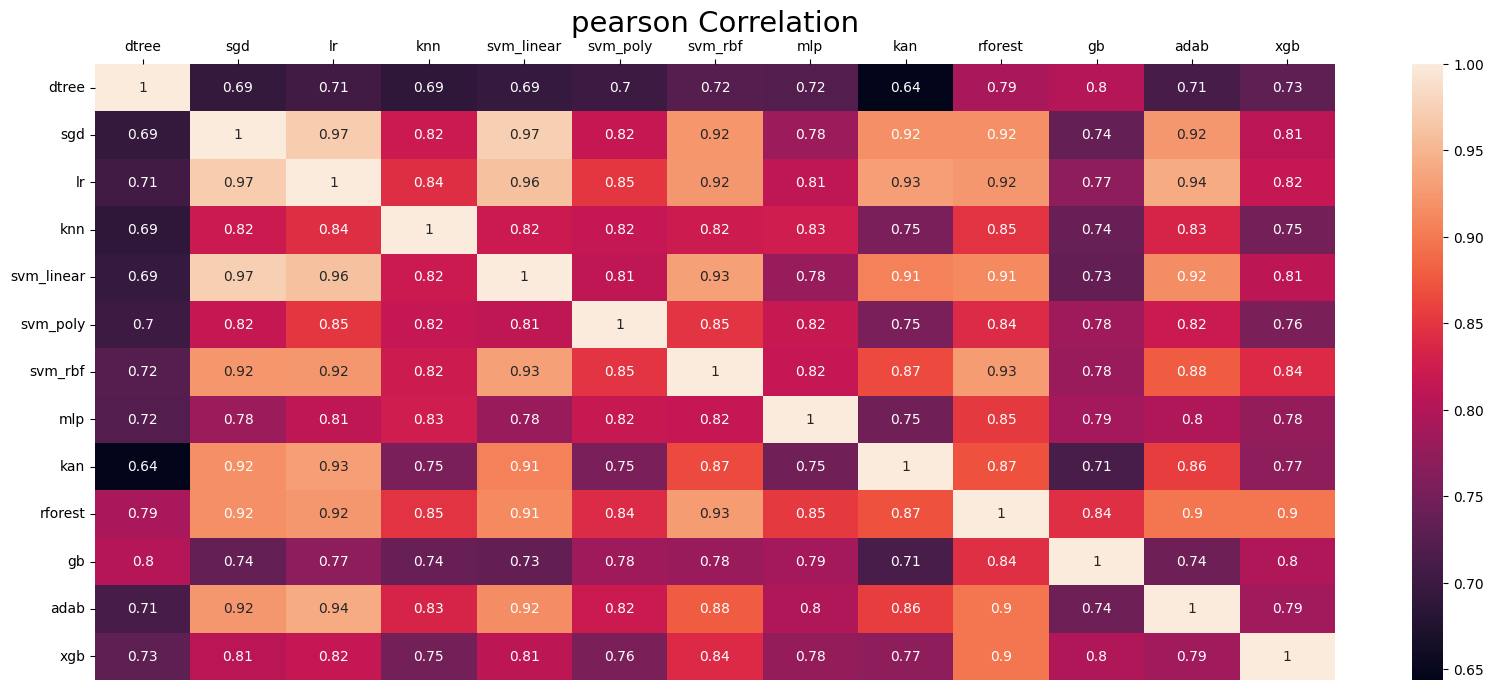

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0292
NMSE: 0.1709
MAE: 0.1498
NMSE: 1.1731
Desvio Padrão: 0.0931


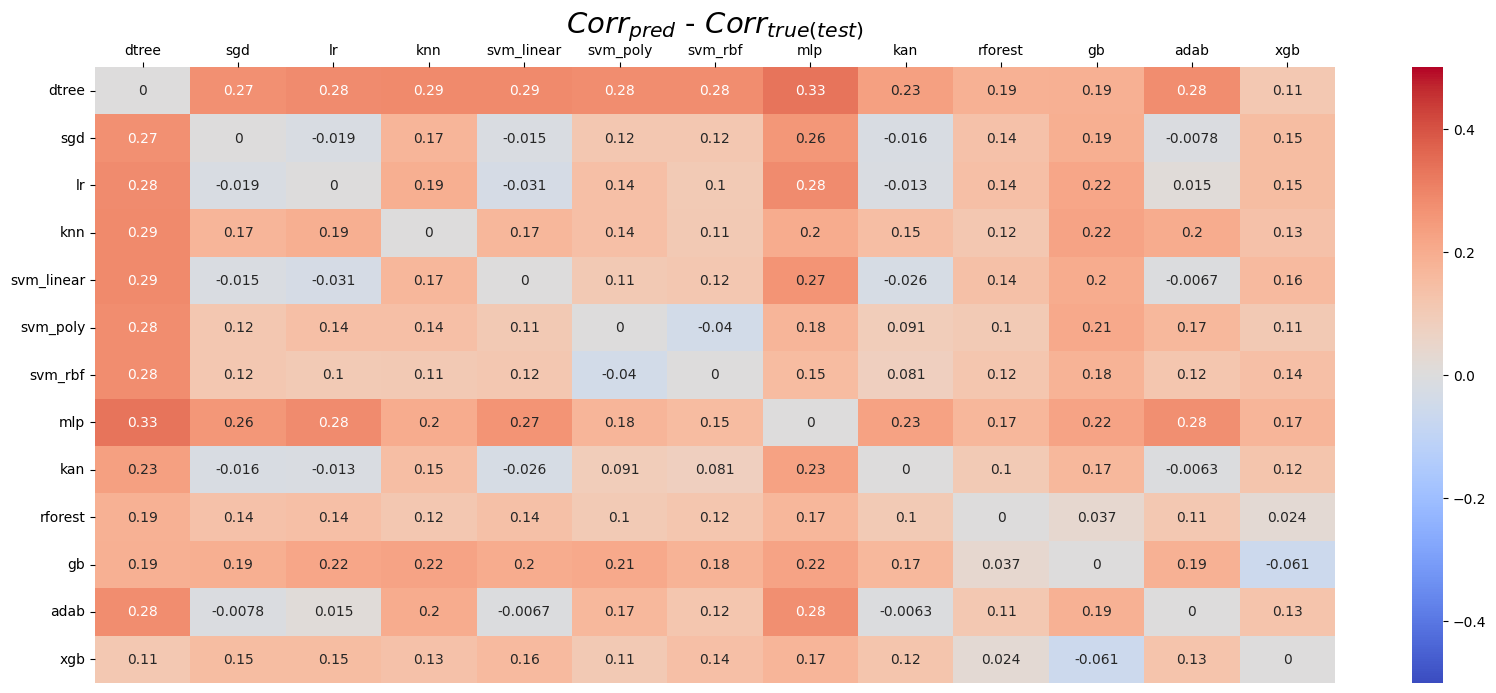

In [147]:
regchainGroups_corrls = y_pred.corr('pearson')
pred_corrls2 = ya_test.corr('pearson')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['regchain(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['regchain(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['regchain(group)',:] = nmse_models(ya_test, y_pred)


plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchainGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

### Multi-Output Regressor

In [148]:
mor4groups = []

for g in groups['true_assessor_train']:
    model = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train[g])
    mor4groups.append(model)

In [149]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mor4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0762
RMSE: 0.2608
MAE: 0.1879
NMSE: 0.7180


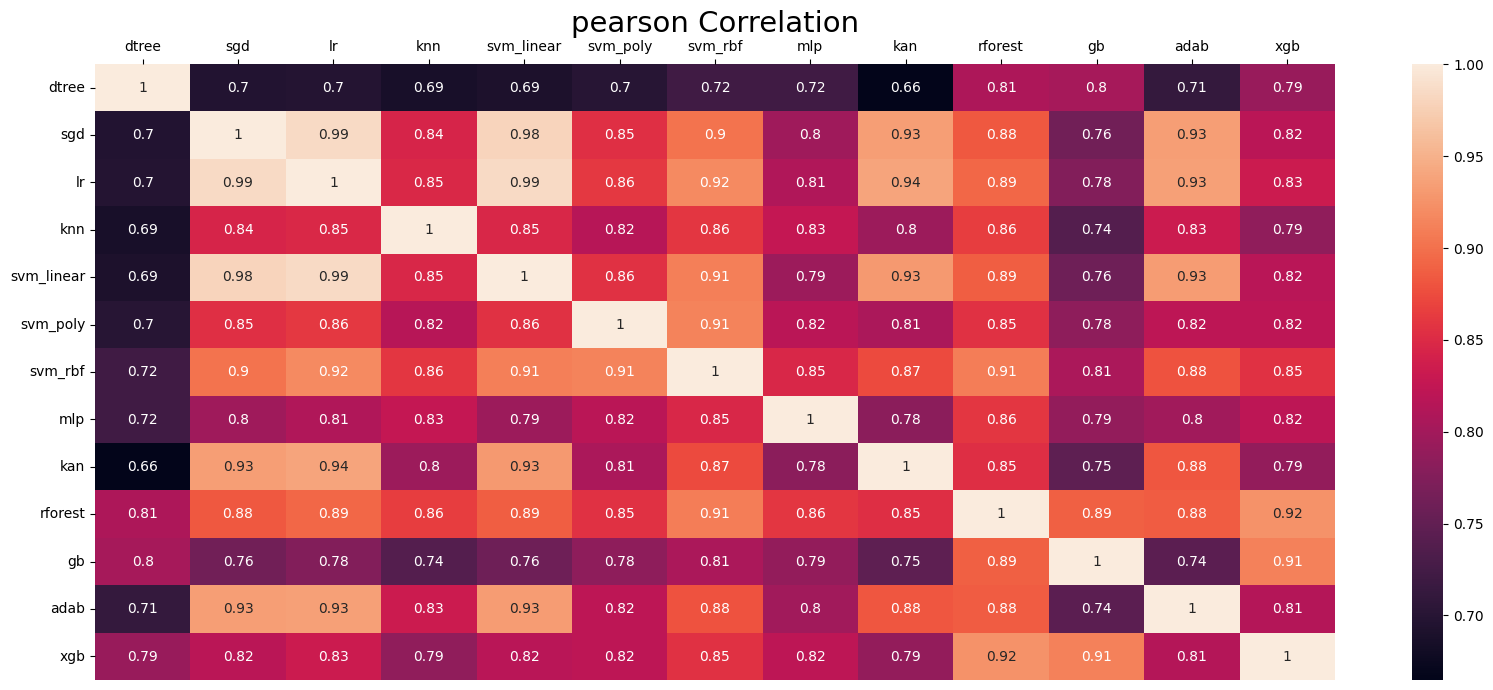

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0323
NMSE: 0.1797
MAE: 0.1578
NMSE: 1.2974
Desvio Padrão: 0.0876


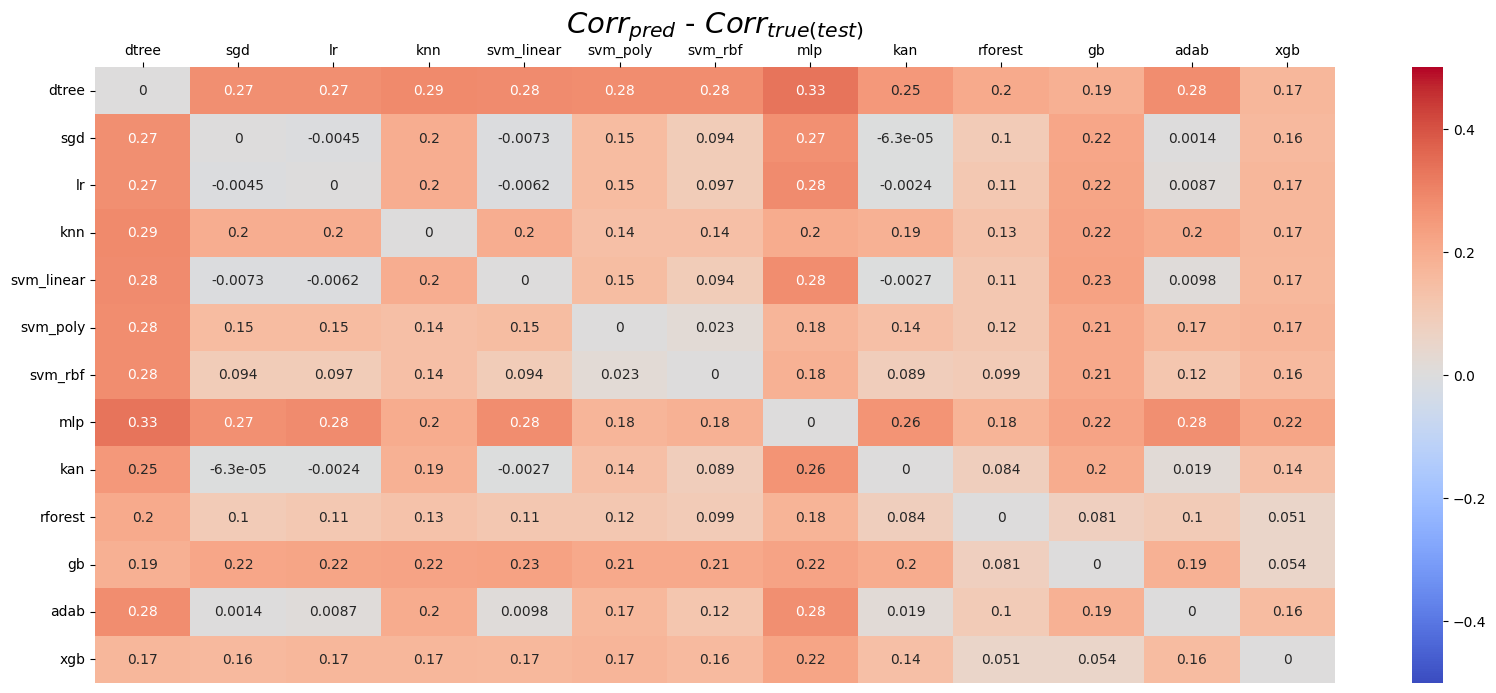

In [150]:
morGroups_corrls = y_pred.corr('pearson')
#pred_corrls2 = ya_test.corr('pearson')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['multi-output(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['multi-output(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['multi-output(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['multi-output(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(morGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = morGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

In [ ]:
mse_df

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.178037,0.033546,0.040910,0.113667,0.039202,0.068335,0.062807,0.132786,0.034860,0.046681,0.128486,0.007077,0.090683
multi-output,0.178037,0.034438,0.040237,0.116835,0.039294,0.071064,0.063544,0.136825,0.035089,0.048856,0.127563,0.007290,0.091512
individual,0.172037,0.032433,0.037757,0.108768,0.036211,0.066569,0.059506,0.126065,0.033023,0.045570,0.120655,0.006783,0.085556
regchain(group),0.178037,0.032992,0.038841,0.116835,0.037366,0.071064,0.060972,0.136825,0.036148,0.044682,0.127563,0.007290,0.092436
multi-output(group),0.178037,0.034438,0.040237,0.116835,0.039294,0.071064,0.063544,0.136825,0.035089,0.048856,0.127563,0.007290,0.091512


## Análises

In [152]:
def metricsFormat(df: pd.DataFrame, metric_name:str):
    df = df.reset_index().melt(id_vars='index', var_name='model', value_name=metric_name)
    df = df.rename(columns={'index': 'assessor_type'})

    return df

In [153]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(rmse_df, 'RMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df

,assessor_type,model,MSE,RMSE,MAE,NMSE
0,regchain,dtree,0.178037,0.421944,0.334889,0.891180
1,multi-output,dtree,0.178037,0.421944,0.334889,0.891180
2,individual,dtree,0.172037,0.414774,0.342495,0.861147
3,regchain(group),dtree,0.178037,0.421944,0.334889,0.891180
4,multi-output(group),dtree,0.178037,0.421944,0.334889,0.891180
...,...,...,...,...,...,...
60,regchain,xgb,0.090683,0.301136,0.223174,0.789897
61,multi-output,xgb,0.091512,0.302509,0.215301,0.797117
62,individual,xgb,0.085556,0.292500,0.210813,0.745241
63,regchain(group),xgb,0.092436,0.304033,0.221824,0.805165


In [264]:
teste = metrics_df.drop(columns=['model']).groupby(['assessor_type']).agg(['mean', 'std'])
teste.to_csv('data/churn/results.csv')
teste

MSE                RMSE                 MAE  \
                         mean       std      mean       std      mean   
assessor_type                                                           
individual           0.071610  0.047877  0.252591  0.091972  0.186849   
multi-output         0.076199  0.050284  0.260778  0.094215  0.187940   
multi-output(group)  0.076199  0.050284  0.260778  0.094215  0.187940   
regchain             0.075160  0.049949  0.258877  0.093921  0.192353   
regchain(group)      0.075465  0.050800  0.259020  0.095247  0.189354   

                                   NMSE            
                          std      mean       std  
assessor_type                                      
individual           0.080991  0.673031  0.136618  
multi-output         0.080890  0.718007  0.143156  
multi-output(group)  0.080890  0.718007  0.143156  
regchain             0.080027  0.706994  0.141635  
regchain(group)      0.080373  0.707797  0.150817

In [154]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[-1], sns.color_palette()[1]]

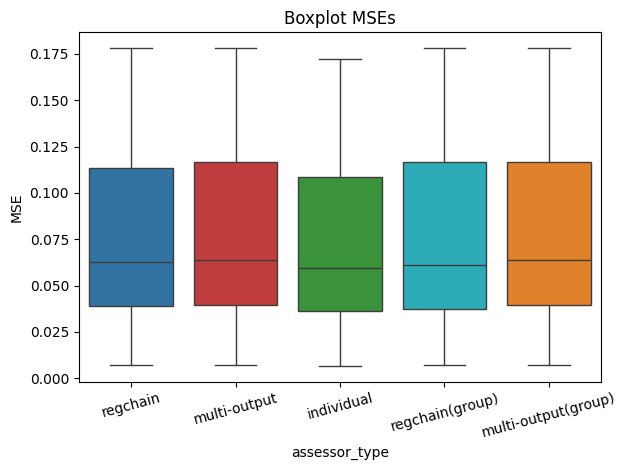

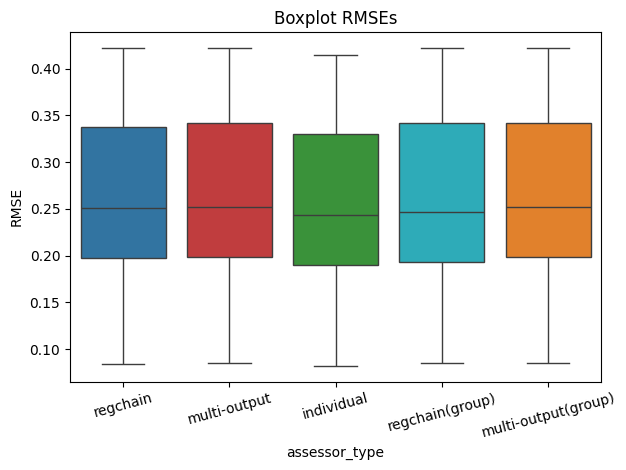

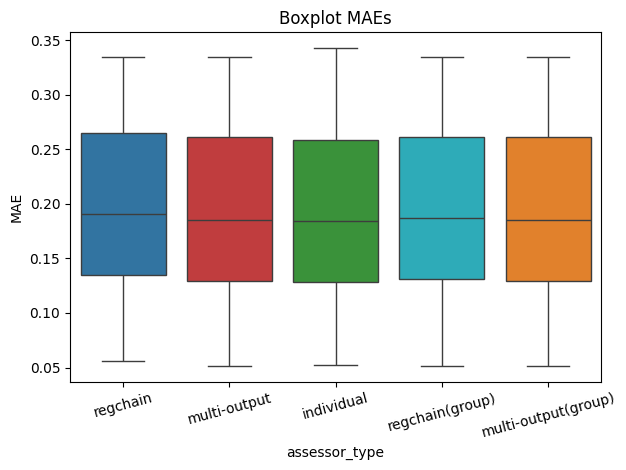

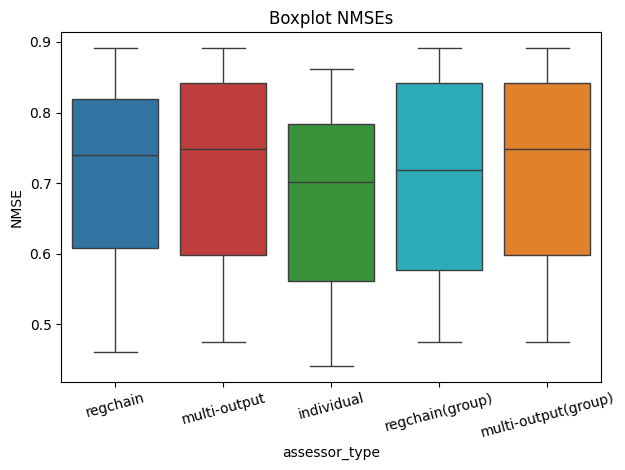

In [155]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.title(f'Boxplot {mt}s')
    sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

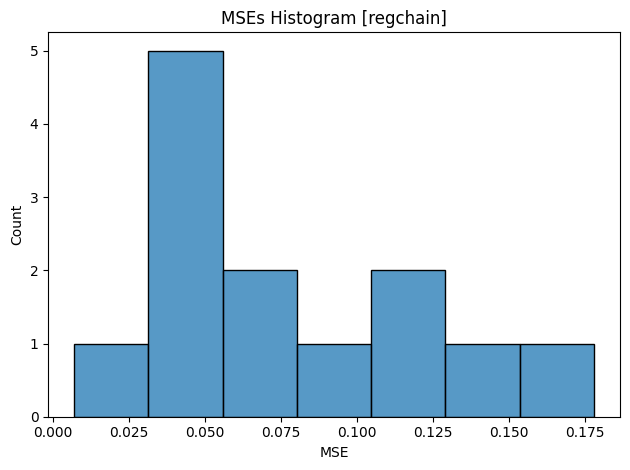

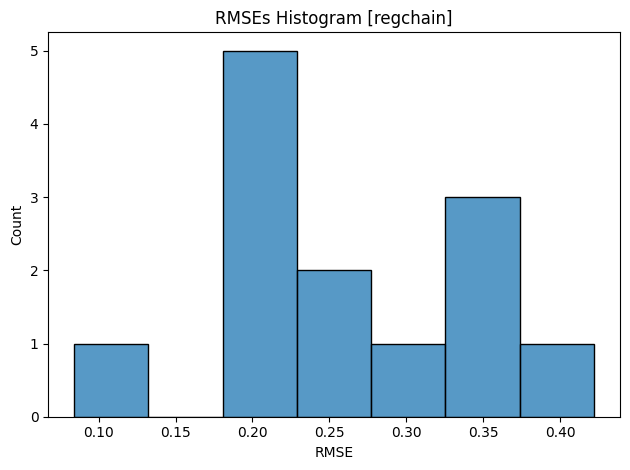

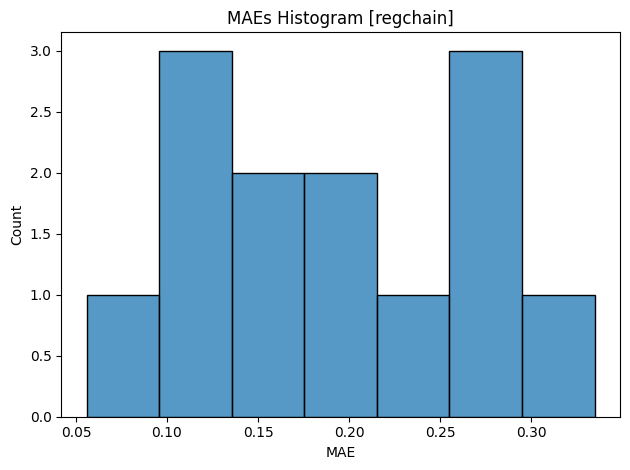

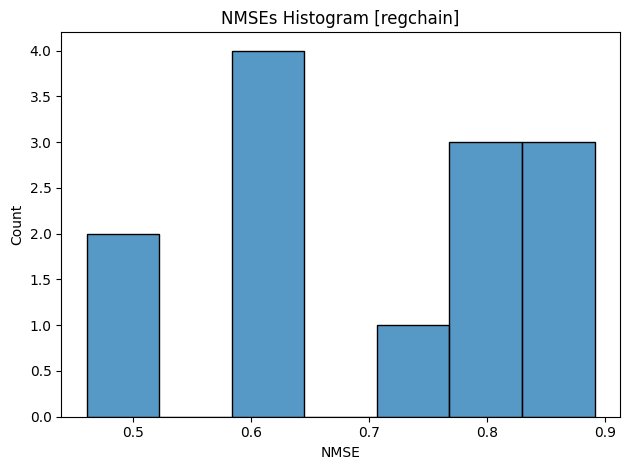

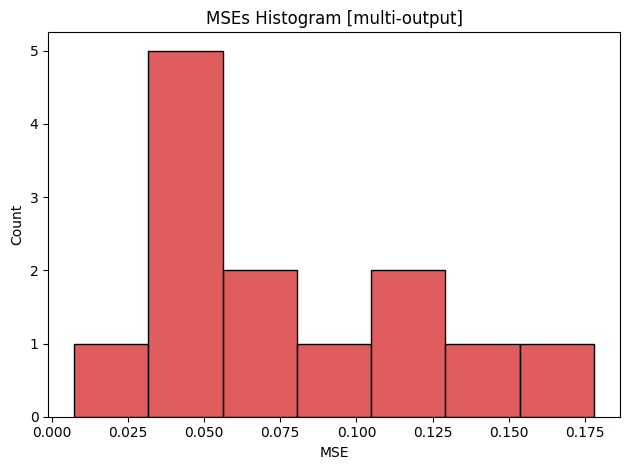

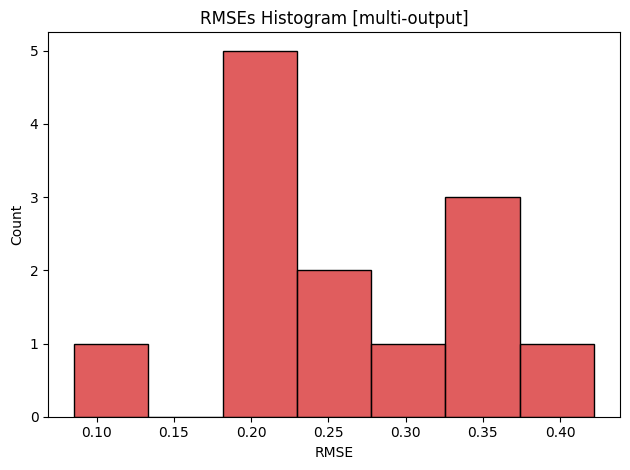

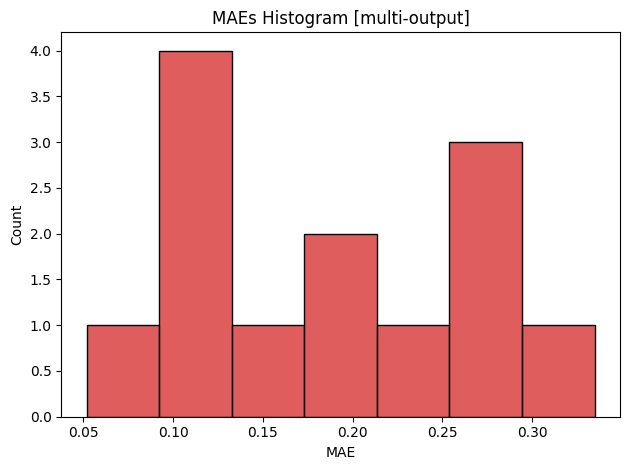

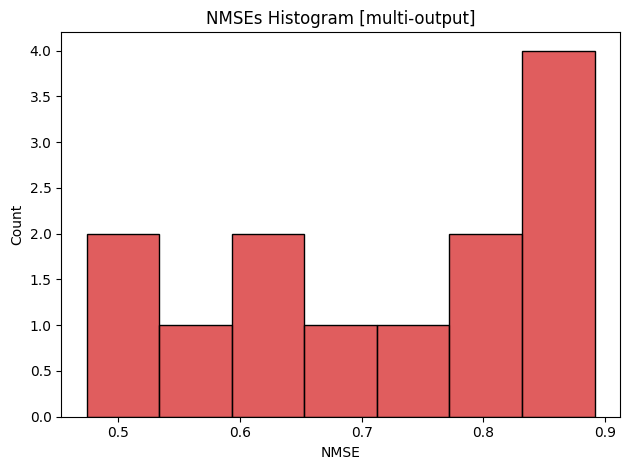

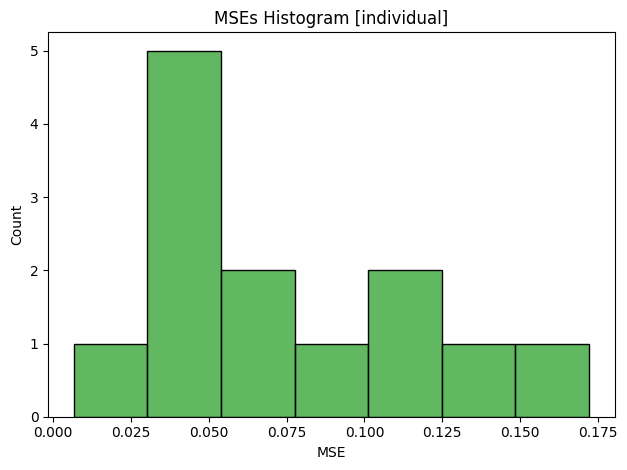

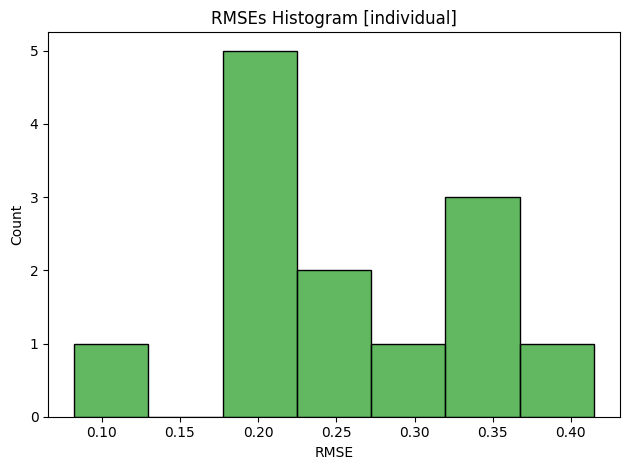

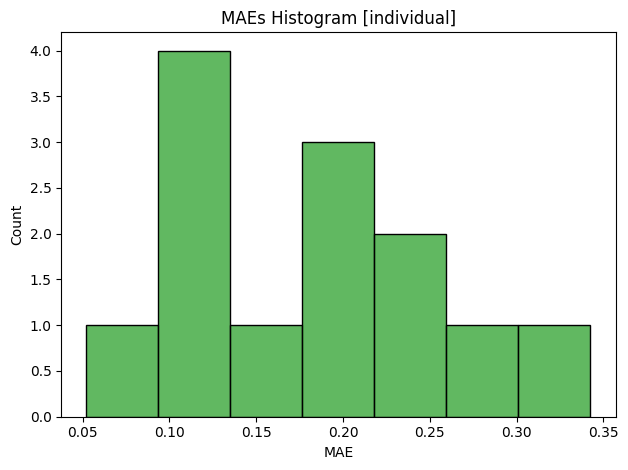

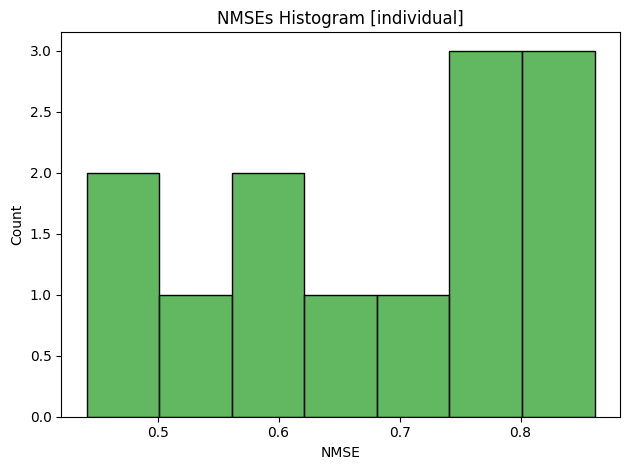

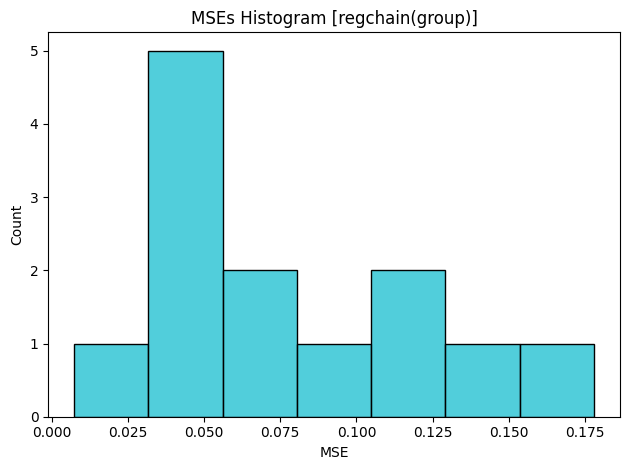

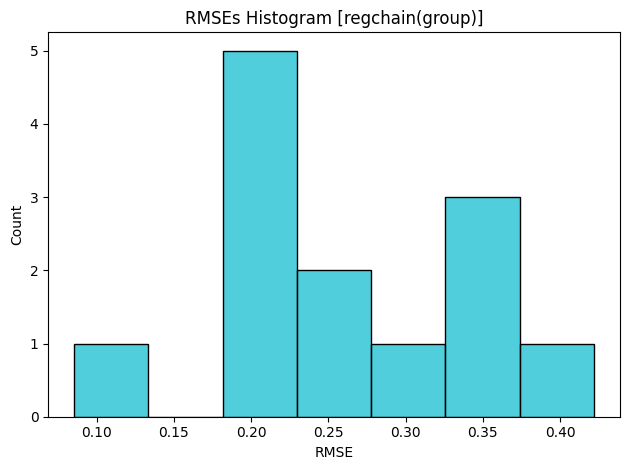

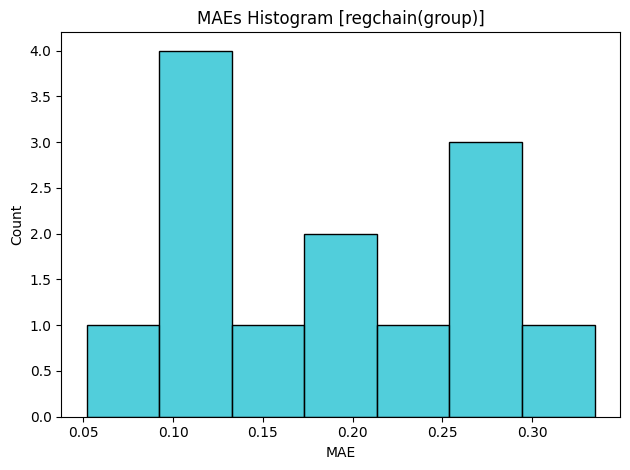

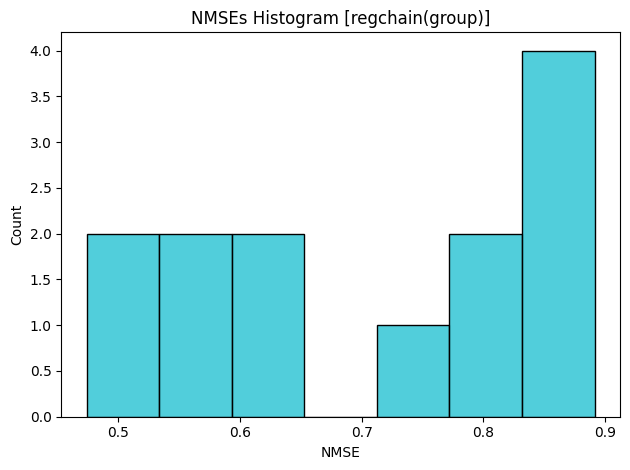

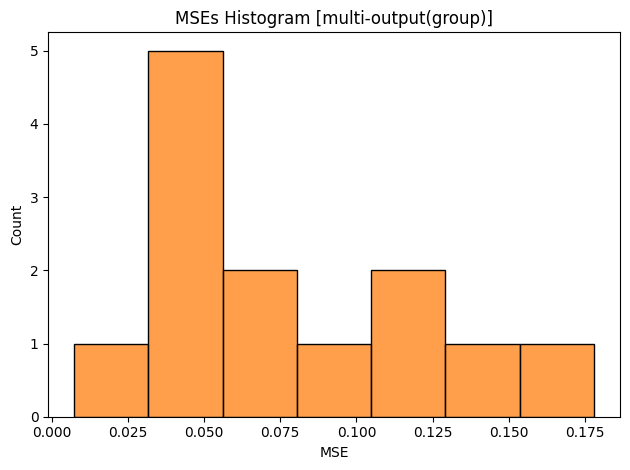

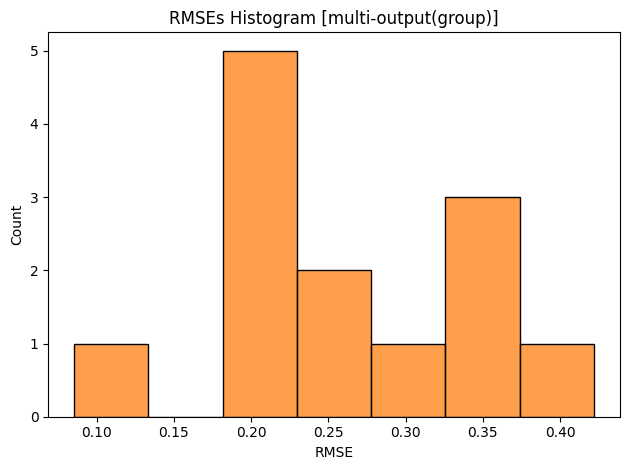

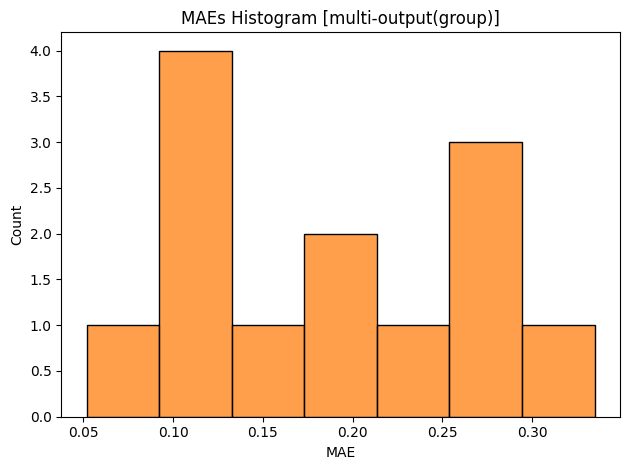

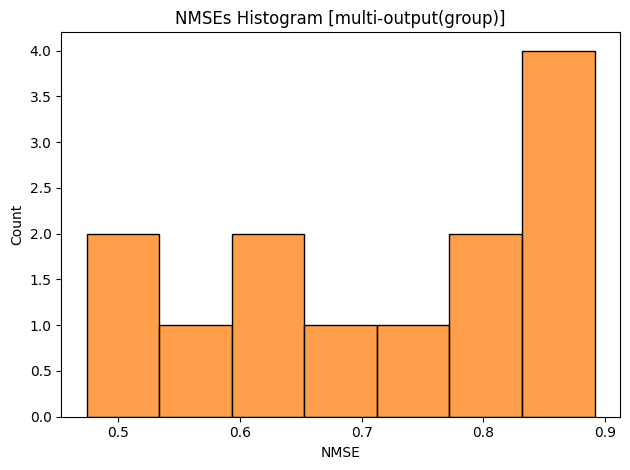

In [156]:
teste = {'regchain': class_palette[0], 
         'multi-output': class_palette[1], 
         'individual': class_palette[2],
         'regchain(group)': class_palette[3],
         'multi-output(group)': class_palette[4]}

for a in teste.keys():
    for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
        plt.title(f'{mt}s Histogram [{a}]')
        sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=teste[a])
        plt.tight_layout()
        plt.show()

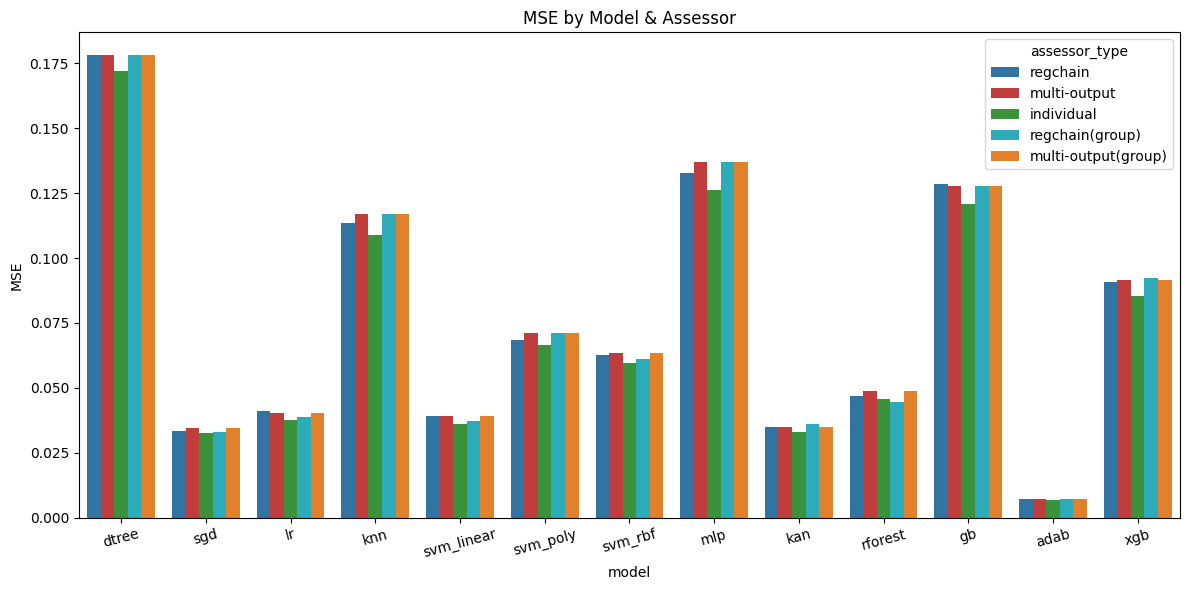

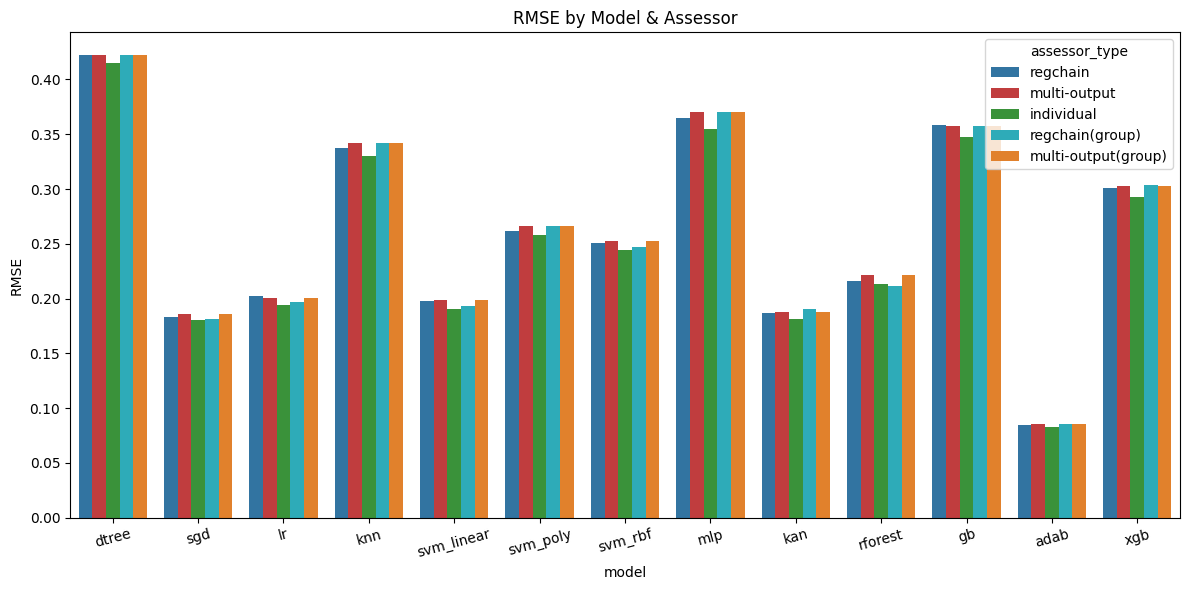

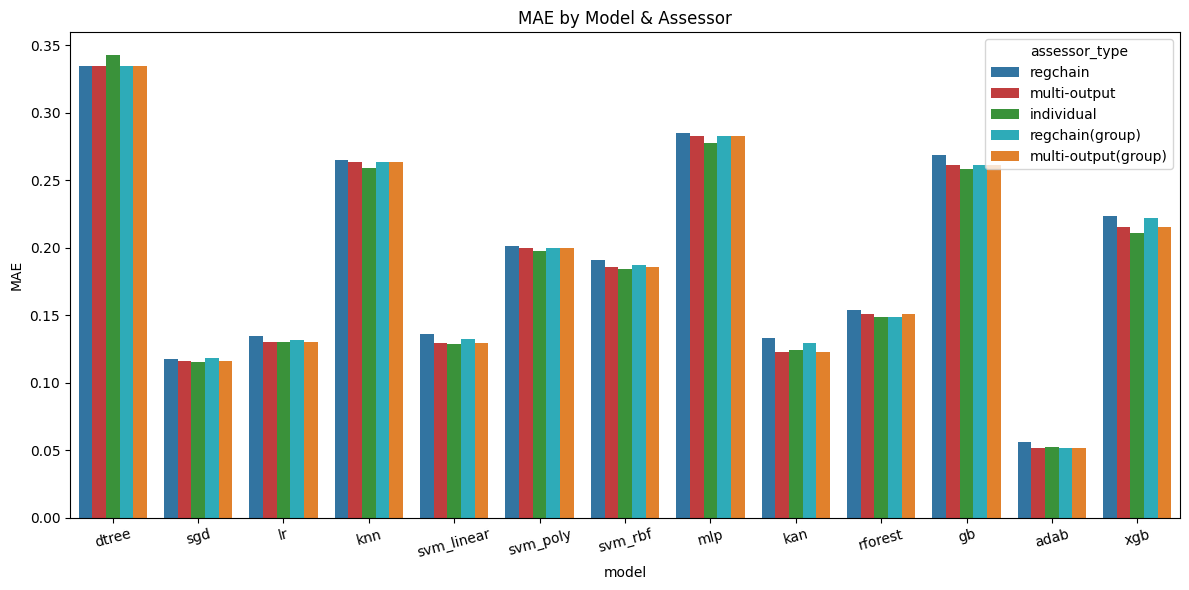

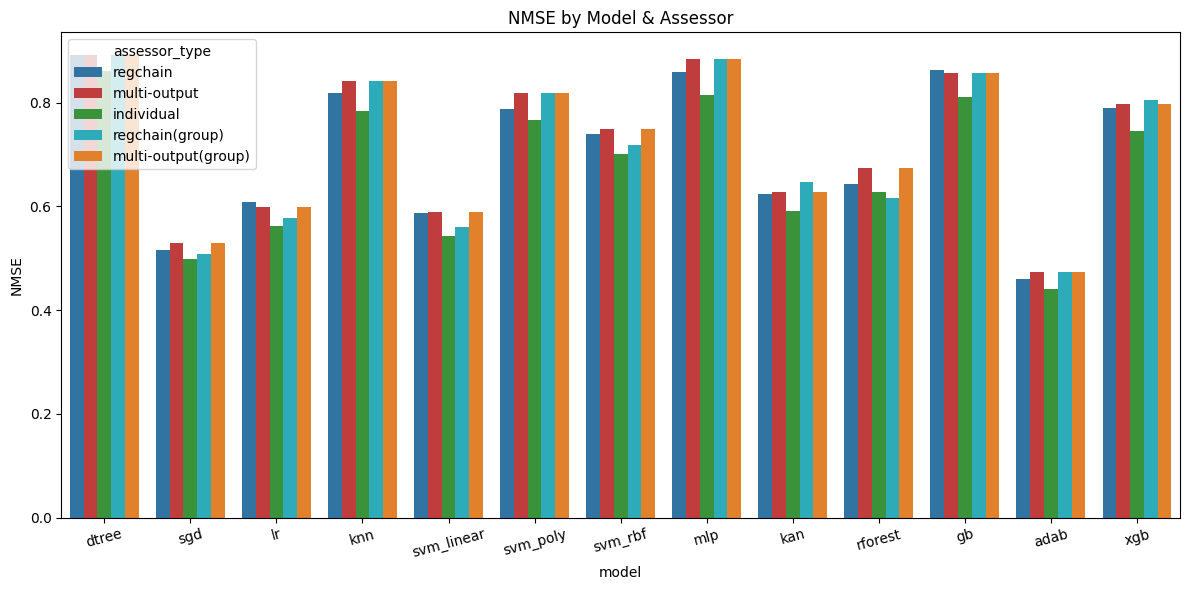

In [157]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()